# 19.08 Challenge
## The Scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

## Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### 19.08 Solution
#### Python Imports

In [726]:
import warnings 
import missingno # Visualizing nulls
import math # ceiling division

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns # heatmap generation
import statsmodels.api as sm

from scipy import stats
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL # facilitates using dict for db connection info
from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore # used in winsorizing

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet 

from sklearn.model_selection import cross_val_score # For cross-validation
from sklearn.model_selection import KFold # For cross-validation

warnings.filterwarnings(action="ignore")

#### User Defined Functions

The functions defined in this section are used to help reduce the verbosity of the cells with the notebook.  They are also available for reuse elsewhere in the notebook.

#### Functions
- `report_null_entries()`: Display a visual representation of nulls in a dataframe.
- `null_rpt_cat_cols()`: Generate a Pandas dataframe that summarizes nulls for the categorical columns
- `null_rpt_contin_cols()`: Generate a Pandas dataframe that summarizes nulls for the continuous columns
- `winsorized_comparison()`: Generate a series of box plots that compare un-winsorized variables to winsorized variables
- `corr_plot()`: Generate a heatmap showing the correlations between variables
- `get_k_fold_scores()`: Return a list of lists for reporting of k-fold scores
- `get_test_scores()`: Helper function to aggregate training and test scores
- `print_stats()`: Helper function to print out the results for model testing and training.

In [5]:
# Generate a visual representation of nulls in the dataset
def report_null_entries(df):
    """Take in a dataframe, and generate a visualization of the null values."""
    
    # Check to make sure that the dataframe has null values, if not say so
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")

        # Call the missingno library to generate the visualization
        missingno.matrix(df)

        # Display the visualization
        plt.show()
    else:
        print("No rows with null values found.")

In [12]:
def null_rpt_cat_cols(df):
    """ This function takes in a dataframe, picks out the categorical columns ('object','category','datetime64[ns]') and reports back the number of nulls, the null percentage and number of unique values. The function also returns a list of the categorical column names."""

    categorical_df = df.select_dtypes(include=["category","object","datetime64[ns]"])

    total_missing = categorical_df.isnull().sum().sort_values(ascending=False)
    percent_missing = (categorical_df.isnull().sum()/categorical_df.isnull().count()).sort_values(ascending=False)
    uniques = categorical_df.nunique().sort_values(ascending=False)

    missing_info = dict(
        total_missing=total_missing, 
        percent_missing=percent_missing, 
        uniques=uniques
    )

    missing_data = pd.DataFrame(missing_info)
    missing_data = missing_data.reset_index()
    missing_data = missing_data.rename(columns=dict(index="cols"))

    return missing_data

In [13]:

def null_rpt_contin_cols(df):
    """ This function takes in a dataframe, excludes the continuous columns ('object','category') and reports back the number of nulls, the null percentage and number of unique values. The function also returns a list of the categorical column names.  Notice that datetime is included, in case you want to treat it as a continuous variable."""

    continuous_df = df.select_dtypes(exclude=["object","category"])

    total_missing = continuous_df.isnull().sum().sort_values(ascending=False)
    percent_missing = (continuous_df.isnull().sum()/continuous_df.isnull().count()).sort_values(ascending=False)
    uniques = continuous_df.nunique().sort_values(ascending=False)

    missing_info = dict(
        total_missing=total_missing, 
        percent_missing=percent_missing, 
        uniques=uniques
    )

    missing_data = pd.DataFrame(missing_info)
    missing_data = missing_data.reset_index()
    missing_data = missing_data.rename(columns=dict(index="cols"))

    return missing_data

In [575]:
def winsorized_comparison(df, col, tup):
    """Create a set of box plots comparing un-winsorized variables to winsorized variables.  Take in a dataframe, a column name, and a tuple pair that delinates the lower and upper cuts for winsorization."""
    plt.figure(figsize=(18,6))

    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of unwinsorized {col}")

    plt.subplot(1,2,2)
    winsorized = winsorize(df[col], tup)
    plt.boxplot(winsorized)
    plt.xticks([1], [f"{col} (winsorized)"])
    plt.title(f"Box Plot of winsorized {col}")

    plt.suptitle(f"Unwinsorized and Winsorized box plots of {col}")
    plt.show()

    q75, q25 = np.percentile(winsorized, [75, 25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outliers = len((np.where((winsorized > max_val) 
                | (winsorized < min_val))[0]))

    pcnt_min = percentileofscore(winsorized, min_val)
    pcnt_max = percentileofscore(winsorized, max_val)
    
    display(f"{col} - IQR Threshold: {1.5:>{4}.1f} | Outliers: {outliers}");

In [616]:
# Plot a correlaiton matrix
def corr_plot(corr_mat,figsize):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(f"Correlation matrix of winsorized variables")

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

In [717]:
def get_k_fold_scores(Y,X): 
    test_scores = list() # Empty list container to hold the cross-test scores

    for i,j in enumerate(range(20,30,10)):
        j/100 # Set the percentage basis for the holdout groups

        random_state = 100 # Set the amount of randomness in in the sampling

        # Test and train groups
        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
            test_size = j, random_state = random_state)

        # Use K-Fold to split the data
        k_fold = KFold(n_splits=5)
        
        # Use a linear regression model
        lrm = LinearRegression()

        cross_test_results = cross_val_score(lrm, X_train, y_train, cv=k_fold)
        test_mean = (cross_test_results.mean())*100
        test_scores.append([i+1,j, test_mean])

    results_df = pd.DataFrame(test_scores, columns=["Fold","Holdout","Mean_Score"])

    return results_df

In [728]:
def print_stats(train_score, test_score, mae_score, mse_score, rmse_score, mape_score):
    """Helper function to print out the results for model testing and training."""
    print(f"R-squared of the model in the training set is: {train_score:,.4f}")
    print("\n", 30*"-", "Test set statistics", 30*"-", "\n")
    print(f"R-squared of the model in the test set is: {test_score:,.4f}")
    print(f"Mean absolute error of the prediction is: {mae_score:,.4f}")
    print(f"Mean squared error of the prediction is: {mse_score:,.4f}")
    print(f"Root mean squared error of the prediction is: {rmse_score:,.4f}")
    print(f"Mean absolute percentage error of the prediction is: {mape_score:,.4f}")

In [722]:
def get_test_scores(model,X_train, X_test, y_train, y_test, y_preds_train, y_preds_test):
    """Helper function to aggregate training and test results."""
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mae_score = mean_absolute_error(y_test, y_preds_test)
    mse_score = mse(y_test, y_preds_test)
    rmse_score = rmse(y_test, y_preds_test)
    mape_score = np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100

    return [train_score, test_score, mae_score, mse_score, rmse_score, mape_score]

#### Load the houseprices data

Retreive the houseprices data from Thinkful's houseprices database.  Load the data into a dataframe, _houses_raw_ in order to create a root dataframe that can be used to retrieve source data without having to hit the database server again.

In [2]:
# Define the database connection info
kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "houseprices"
)

In [3]:
# Load the data from the medicalcosts database
engine=create_engine(URL(**kagle), echo=True)

houses_raw = pd.read_sql("SELECT * FROM houseprices", con=engine)

# No need for an open connection, please close
engine.dispose()

2020-01-11 13:03:49,085 INFO sqlalchemy.engine.base.Engine select version()
2020-01-11 13:03:49,086 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,189 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-11 13:03:49,189 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,287 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-11 13:03:49,290 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,341 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-11 13:03:49,341 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,390 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-11 13:03:49,392 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,491 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

In [4]:
# Create a copy of the raw data to work on
houses_working = houses_raw.copy()

### Data Cleaning

After an initial _working_ copy of the data has been made, take a look at it to assess the null situation.  As illustrated below, several variables are missing a signifigant amount of information.

Number of null values: 1460


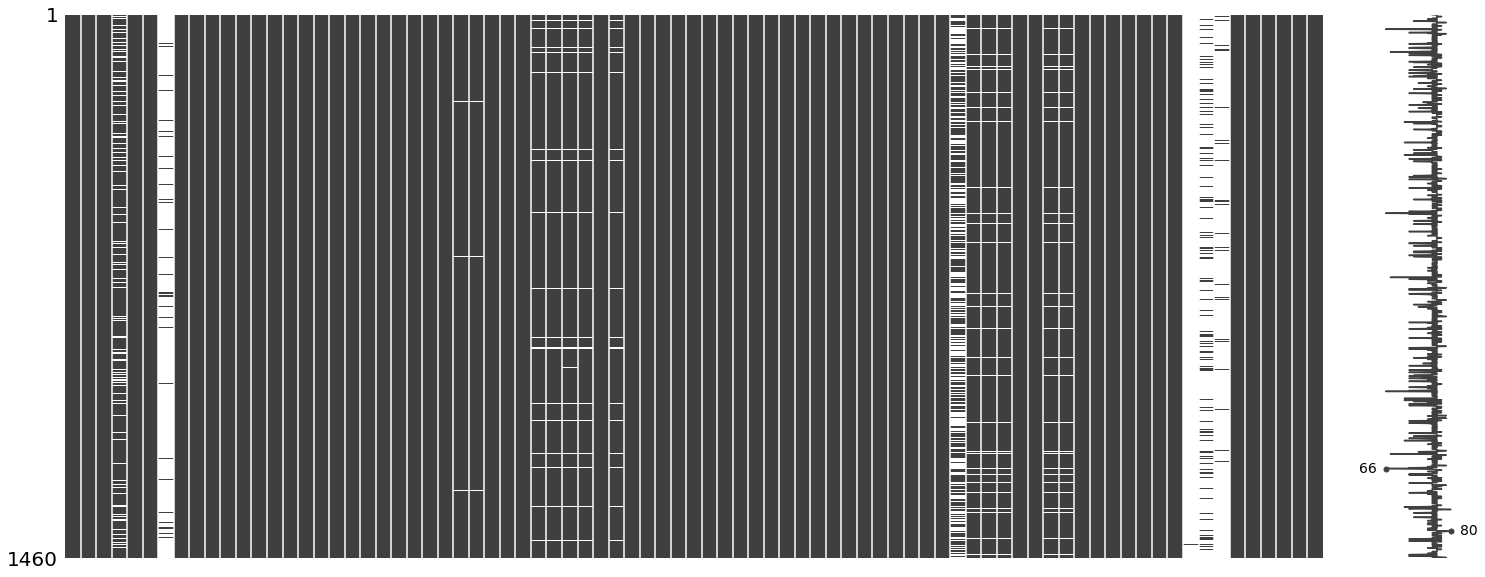

In [10]:
# Generate a visual of missing values in houses_working
report_null_entries(houses_working)

In [14]:
# Run the null report function for categorical columns
cat_cols = null_rpt_cat_cols(houses_working)

# Display only the columns with null values
cat_cols[cat_cols["total_missing"]>0].sort_values(by="total_missing",ascending=False)

cols  total_missing  percent_missing  uniques
36        poolqc           1453         0.995205        3
32   miscfeature           1406         0.963014        4
0          alley           1369         0.937671        2
15         fence           1179         0.807534        4
16   fireplacequ            690         0.472603        5
19    garagecond             81         0.055479        5
20  garagefinish             81         0.055479        3
21    garagequal             81         0.055479        5
22    garagetype             81         0.055479        6
3   bsmtexposure             38         0.026027        4
5   bsmtfintype2             38         0.026027        6
2       bsmtcond             37         0.025342        4
4   bsmtfintype1             37         0.025342        6
6       bsmtqual             37         0.025342        4
31    masvnrtype              8         0.005479        4
10    electrical              1         0.000685        5

It is the case that not all null values are the same.  In this dataset "NA" in categorical variables menas no "x" category: 
- _poolqu_: Pool Quality
    - _poolqc_ can be addresses with targeted filling as the number of nulls == the number of _poolarea_ == 0
    - the "NA" value will be changed to "no_pool"
- _miscfeature_: Miscellaneous feature not covered in other categories
    - _miscfeature_ can be addressed with targeted filling as the number of nulls == the number of _miscval_ == 0
    - the "NA" value will be changed to "no_misc"
- _alley_ will be dropped for insufficient data
- _fence_ will be dropped for insufficient data 
- _fireplacequ_: Fireplace Quality
    - _fireplacequ_ can be addressed with targeted filling as the number of nulls == the number of _fireplaces_ == 0
    - the "NA" value will be changed to "no_fireplace"
- The garage categories: _garagecond, garagefinish, garagequal, garagetype_, Garage Condition, Garage Finish, Garage Quality, and Garage Type respectivly, can be consolidated and checked against _garagearea_.
    - _garagecond, garagefinish, garagequal, garagetype_ can be addressed with targeted filling as the number of nulls == the number of _garagearea_ == 0
    - The "NA" value for this category group will be changed to "no_garage"
- Like the garage categories, the basement categories: _bsmtexposure, bsmtfintype2, bsmtcond, bsmtfintype1, & bsmtqual_, Basement Exposure, Basement Finish Type 2, Basement Condition, Basement Finsh Type 1, and Basement Quality respectively can be consolidated and checked against _totalbsmtsf_.
    - _bsmtexposure, bsmtfintype2, bsmtcond, bsmtfintype1, & bsmtqual_ can be addressed with targeted filling as the number of nulls == the number of _totalbsmtsf_ == 0
    - The "NA" values for this category group will be changed to "no_basement"
- _masvnrtype_: Masonry Veneer Type
    - _masvnrtype_ can be addressed with targeted filling as a "NA" value means no masonry, change to "no_masonry"
- _electrical_: Electrical System
    - _electrical_ can be addressed with targeted filling, the "NA" value will be replaced with "sbrkr"
    - A check against the Year Built (_yearbuilt_) variable reveals that the home was constructed in 2006 and modern building codes require circuit breakers.  The null value probably arises from an data entry error.

I'll quantify these insights below.  The quantitative basis illustrate the relationship between the categorical variables and the continuous variable that they are checked against.

In [112]:
# poolqc - Retrieve the null poolqc observations and then check against reference variables
null_poolqc = houses_working[houses_working["poolqc"].isnull()]
validator_poolqc = houses_working[(houses_working["poolqc"].isnull()) & (houses_working["poolarea"]==0)]

# miscfeature - Retrieve the null miscfeature observations and then check against reference variables
null_miscfeature = houses_working[houses_working["miscfeature"].isnull()]
validator_miscfeature = houses_working[(houses_working["miscfeature"].isnull()) & (houses_working["miscval"]==0)]

# fireplacequ - Retrieve the null fireplacequ observations and then check against reference variables
null_fireplacequ = houses_working[houses_working["fireplacequ"].isnull()]
validator_fireplacequ = houses_working[(houses_working["fireplacequ"].isnull()) & (houses_working["fireplaces"]==0)]

# garage categories - Aggregrate the garage categories and check against the reference variable
null_garage_cats = houses_working[(houses_working["garagecond"].isnull()) & 
    (houses_working["garagefinish"].isnull()) & 
    (houses_working["garagequal"].isnull()) & 
    (houses_working["garagetype"].isnull())]
validator_null_garage_cats = houses_working[(houses_working["garagecond"].isnull()) & 
    (houses_working["garagefinish"].isnull()) & 
    (houses_working["garagequal"].isnull()) & 
    (houses_working["garagetype"].isnull()) & 
    (houses_working["garagearea"]==0)]

# basement categories - Aggregate the basement categories and check against the reference variable
null_basement_cats = houses_working[(houses_working["bsmtexposure"].isnull()) & 
    (houses_working["bsmtcond"].isnull()) & 
    (houses_working["bsmtfintype1"].isnull()) & 
    (houses_working["bsmtqual"].isnull())]
validator_null_basement_cats = houses_working[(houses_working["bsmtexposure"].isnull()) & 
    (houses_working["bsmtcond"].isnull()) & 
    (houses_working["bsmtfintype1"].isnull()) & 
    (houses_working["bsmtqual"].isnull()) &
    (houses_working["totalbsmtsf"]==0)]

# Bring the null counts and validation into a dataframe for display
validators = [["poolqc",len(null_poolqc), len(validator_poolqc)], 
    ["miscfeature",len(null_miscfeature), len(validator_miscfeature)],
    ["fireplacequ",len(null_fireplacequ), len(validator_fireplacequd)], 
    ["garage_categories",len(null_garage_cats), len(validator_null_garage_cats)],
    ["basement_categories",len(null_basement_cats), len(validator_null_basement_cats)]]

display(pd.DataFrame(validators, columns=["variable","variable_nulls","quanitative_check"]))

# Validating the missing observation for the electrical value as modern construction
yr_built = houses_working["yearbuilt"].loc[houses_working["electrical"].isnull()].item()
print(f"\nValidating modern construction for missing electrical variable observation; year built: {yr_built}")

variable  variable_nulls  quanitative_check
0               poolqc            1453               1453
1          miscfeature            1406               1406
2          fireplacequ             690                690
3    garage_categories              81                 81
4  basement_categories              37                 37


Validating modern construction for missing electrical variable observation; year built: 2006


I'll deal with the null replacement shortly but first, I'll examine the nulls for the continuous variables.  As you can see below there are three continuous columns with null values that must be dealt with.

In [15]:
# Run the null report function for condinuous columns
contin_cols = null_rpt_contin_cols(houses_working)

# Display only the columns with null values
contin_cols[contin_cols["total_missing"]>0].sort_values(by="total_missing",ascending=False)

cols  total_missing  percent_missing  uniques
18  lotfrontage            259         0.177397      110
12  garageyrblt             81         0.055479       97
20   masvnrarea              8         0.005479      327

- _lotfrontage_: Linear feet of street connected to property
    - With regard to null values in the lotfrontage variable I was not able to establish a method for calculating the frontage from other variable.  I'll use interpolation to fill the median value for the variable using the _mszoning_ and _neighborhood_ variables to narrow the value options.
- _garageyrblt_: The year the garage was built
    - This variable has a relationship with the categorical variables, _garagetype_ and _garagefinish_.  When these variable have null values, there is no garage.  To keep from dropping the rows entirely, I'll fill the _garageyrblt_ variable with the value in the _yearbuilt_ variable for the observation.
- _masvnrarea_: Masonry veneer type
    - _masvnrarea_ can filled with a zero as the variables _masvnrtype_, _exterior1st_, _exterior2nd_ verify that a zero value is approprate.

In [291]:
# Nulls in "lotfrontage"
lotfrontage_nulls = contin_cols.loc[18,"total_missing"]

# Nulls in "garageyrblt"
garageyrblt_nulls = contin_cols.loc[12,"total_missing"]

# Nulls in "masvnrarea"
masvnrarea_nulls = contin_cols.loc[20,"total_missing"]

# Verify that the number of the nulls in "garageyrblt" == null values in "garagetype", "garagefinish"
validator_garageyrblt_nulls = houses_working[["yearbuilt","garageyrblt",
    "garagetype","garagefinish"]].loc[houses_working["garageyrblt"].isnull()]

# Verify that the number of nulls in "masvnrarea" == null values in "masvnrtype", "exterior1st","exterior2nd"
houses_working[["masvnrarea","masvnrtype",
    "exterior1st","exterior2nd"]].loc[(houses_working["masvnrarea"].isnull())]

# Verify that number of nulls in "msicfeature" == 0 in the "miscval" variable
houses_working[(houses_working["miscfeature"].isnull()) & (houses_working["miscval"]==0)]

# Bring the null totals and validators into a dataframe for display
validators2 = [["lotfrontage", lotfrontage_nulls, 0],
    ["garageyrblt",garageyrblt_nulls,len(validator_garageyrblt_nulls)], 
    ["masvnrarea",masvnrarea_nulls,len(validator_masvnrarea_nulls)]]

display(pd.DataFrame(validators2, columns=["variable","variable_nulls","quanitative_check"]))

variable  variable_nulls  quanitative_check
0  lotfrontage             259                  0
1  garageyrblt              81                 81
2   masvnrarea               8                  8

In [382]:
# Replace null values in continuous columns first 
houses_df = houses_working.copy()

# Replace nulls in "lotfrontage" transformation
houses_df["lotfrontage"] = houses_df.groupby(["mszoning",
    "neighborhood"])["lotfrontage"].transform(lambda x: x.fillna(x.median()))

# Assign value of null observation to anomymous variable for immediate use to make mean operation more readable
_ = houses_df[["lotarea"]].iloc[466].values[0]
# Get the mean of the closest five observations that cover a similar area
_ = houses_df.iloc[(houses_df["lotarea"] - _).abs().argsort()[:5]]["lotfrontage"].mean()
# Fill the remaining null observation with the anonymous variable from above
houses_df["lotfrontage"].fillna(_,inplace=True)

# Fill "garageyrblt" with value from "hearbuilt"
houses_df["garageyrblt"].fillna(houses_df["yearbuilt"],inplace=True)

# Fill "masvnrarea" with zero where "masvnrtype", "exterior1st", "exterior2nd" are null
houses_df.loc[(houses_df["masvnrtype"].isnull()) & (houses_df["masvnrarea"].isnull()), "masvnrarea"] = 0

# Fill null poolqc with "no_pool" where poolarea == 0
houses_df.loc[(houses_df["poolqc"].isnull()) & 
    (houses_df["poolarea"]==0),"poolqc"] = "no_pool"

# Fill null miscfeature with "no_misc" where the calculated value == 0
houses_df.loc[(houses_df["miscfeature"].isnull()) & (houses_df["miscval"]==0), "miscfeature"] = "no_misc"

# Fill null fireplacequ with "no_fireplace" where the number of fireplaces == 0
houses_df.loc[(houses_df["fireplacequ"].isnull()) & (houses_df["fireplaces"]==0), "fireplacequ"] = "no_fireplace"

# Fill the garage categroicals: garagecond, garagefinish, garagequal, garagetype 
# with "no_garage" where garagearea == 0
houses_df.loc[(houses_df["garagearea"]==0), ["garagecond","garagefinish","garagequal","garagetype"]] = "no_garage"

# Fill the basement categroicals: bsmtexposure, bsmtcond, bsmtfintype1, bsmtqual 
# with "no_basement" where totalbsmtsf == 0
houses_df.loc[(houses_df["totalbsmtsf"]==0), ["bsmtexposure","bsmtcond","bsmtfintype1","bsmtqual"]] = "no_basement"

# Deal with remaing observation of null bsmtexposure by filling with "No"
houses_df.fillna("No",inplace=True)

# Fill masvnrtype with "no_masonary" as null values == no masonary
houses_df["masvnrtype"].fillna("no_masonary",inplace=True)

# Fill the missing observation for electrical 
houses_df["electrical"].fillna("sbrkr",inplace=True)

null_lotfrontage = houses_df["lotfrontage"].isnull().sum()
null_garageyrblt = houses_df["garageyrblt"].isnull().sum()
null_masvnrarea = houses_df["masvnrarea"].isnull().sum()
null_poolqc = houses_df["poolqc"].isnull().sum()
null_miscfeature = houses_df["miscfeature"].isnull().sum()
null_fireplacequ = houses_df["fireplacequ"].isnull().sum()
null_garage_categories = houses_df[["garagecond","garagefinish","garagequal","garagetype"]].isnull().sum()
null_basement_categories = houses_df[["bsmtexposure", "bsmtcond", "bsmtfintype1", "bsmtqual"]].isnull().sum()
null_masvnrtype = houses_df["masvnrtype"].isnull().sum()
null_electrical = houses_df["electrical"].isnull().sum()

print(f"Null lotfrontage: {null_lotfrontage}")
print(f"Null garageyrblt: {null_garageyrblt}")
print(f"Null masvnrarea: {null_masvnrarea}")
print(f"Null poolqc: {null_poolqc}")
print(f"Null miscfeature: {null_miscfeature}")
print(f"Null fireplacequ: {null_fireplacequ}")
print(f"Null garage categories: {null_garage_categories}")
print(f"Null basement categories: {null_basement_categories}")
print(f"Null masvnrtype: {null_masvnrtype}")
print(f"Null electrical: {null_electrical}")

Null lotfrontage: 0
Null garageyrblt: 0
Null masvnrarea: 0
Null poolqc: 0
Null miscfeature: 0
Null fireplacequ: 0
Null garage categories: garagecond      0
garagefinish    0
garagequal      0
garagetype      0
dtype: int64
Null basement categories: bsmtexposure    0
bsmtcond        0
bsmtfintype1    0
bsmtqual        0
dtype: int64
Null masvnrtype: 0
Null electrical: 0


In [383]:
# Remove the alley and fence variables from consideration
houses_df.drop(columns=["alley","fence"], inplace=True)

Drop the variables, _alley_ and _fence_ as I was unable to sufficiently deal with quantity of null values in each variable.

In [411]:
# Take one more look at the nulls
report_null_entries(houses_df)

No rows with null values found.


After an initial look a scatter plots of the data I want to retype some of the variables.  As illustrated below, I've moved several variables to datetime and group of perviously continuous variables to categorical.  While these variables are numeric by nature they are discrete and work better as categories.

In [432]:
# Change the data type for the below variables to datatime64[ns], 4-digit yr
year_cols = ["yearbuilt","yearremodadd","garageyrblt","yrsold"]
for col in year_cols:
    houses_df[f"{col}"] = pd.to_datetime(houses_df[f"{col}"], format="%Y")

# Change the data type for the below variable to dattime64[ns], 2-digit month
houses_df["mosold"] = pd.to_datetime(houses_df["mosold"], format="%m")

display(houses_df.select_dtypes(include="datetime").info())

# Change the data type for the variables below to categorical
change_to_cat = ["mssubclass", "overallqual", "overallcond", 
    "bsmtfullbath", "bsmthalfbath", "fullbath", 
    "halfbath", "bedroomabvgr", "kitchenabvgr", 
    "totrmsabvgrd", "fireplaces", "garagecars"]
houses_df[change_to_cat] = houses_df[change_to_cat].astype("category")

display(houses_df.select_dtypes(include="category").info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
yearbuilt       1460 non-null datetime64[ns]
yearremodadd    1460 non-null datetime64[ns]
garageyrblt     1460 non-null datetime64[ns]
mosold          1460 non-null datetime64[ns]
yrsold          1460 non-null datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 57.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
mssubclass      1460 non-null category
overallqual     1460 non-null category
overallcond     1460 non-null category
bsmtfullbath    1460 non-null category
bsmthalfbath    1460 non-null category
fullbath        1460 non-null category
halfbath        1460 non-null category
bedroomabvgr    1460 non-null category
kitchenabvgr    1460 non-null category
totrmsabvgrd    1460 non-null category
fireplaces      1460 non-null category
garagecars      1460 non-null category
dtypes: category(12)
memory usage: 20.7 KB


None

### Exploratory Data Analysis EDA

After addressing nulls and retyping I'm left with the following continuous variables: _lotfrontage_, _lotarea_, _masvnrarea_, _bsmtfinsf1_, _bsmtfinsf2_, _bsmtunfsf_, _totalbsmtsf_, _firstflsf_, _secondflrsf_, _lowqualfinsf_, _grlivarea_, _garagearea_, _wooddecksf_, _openporchsf_, _enclosedporch_, _threescreenporch_, _screenporch_, _poolarea_, and _miscval_.

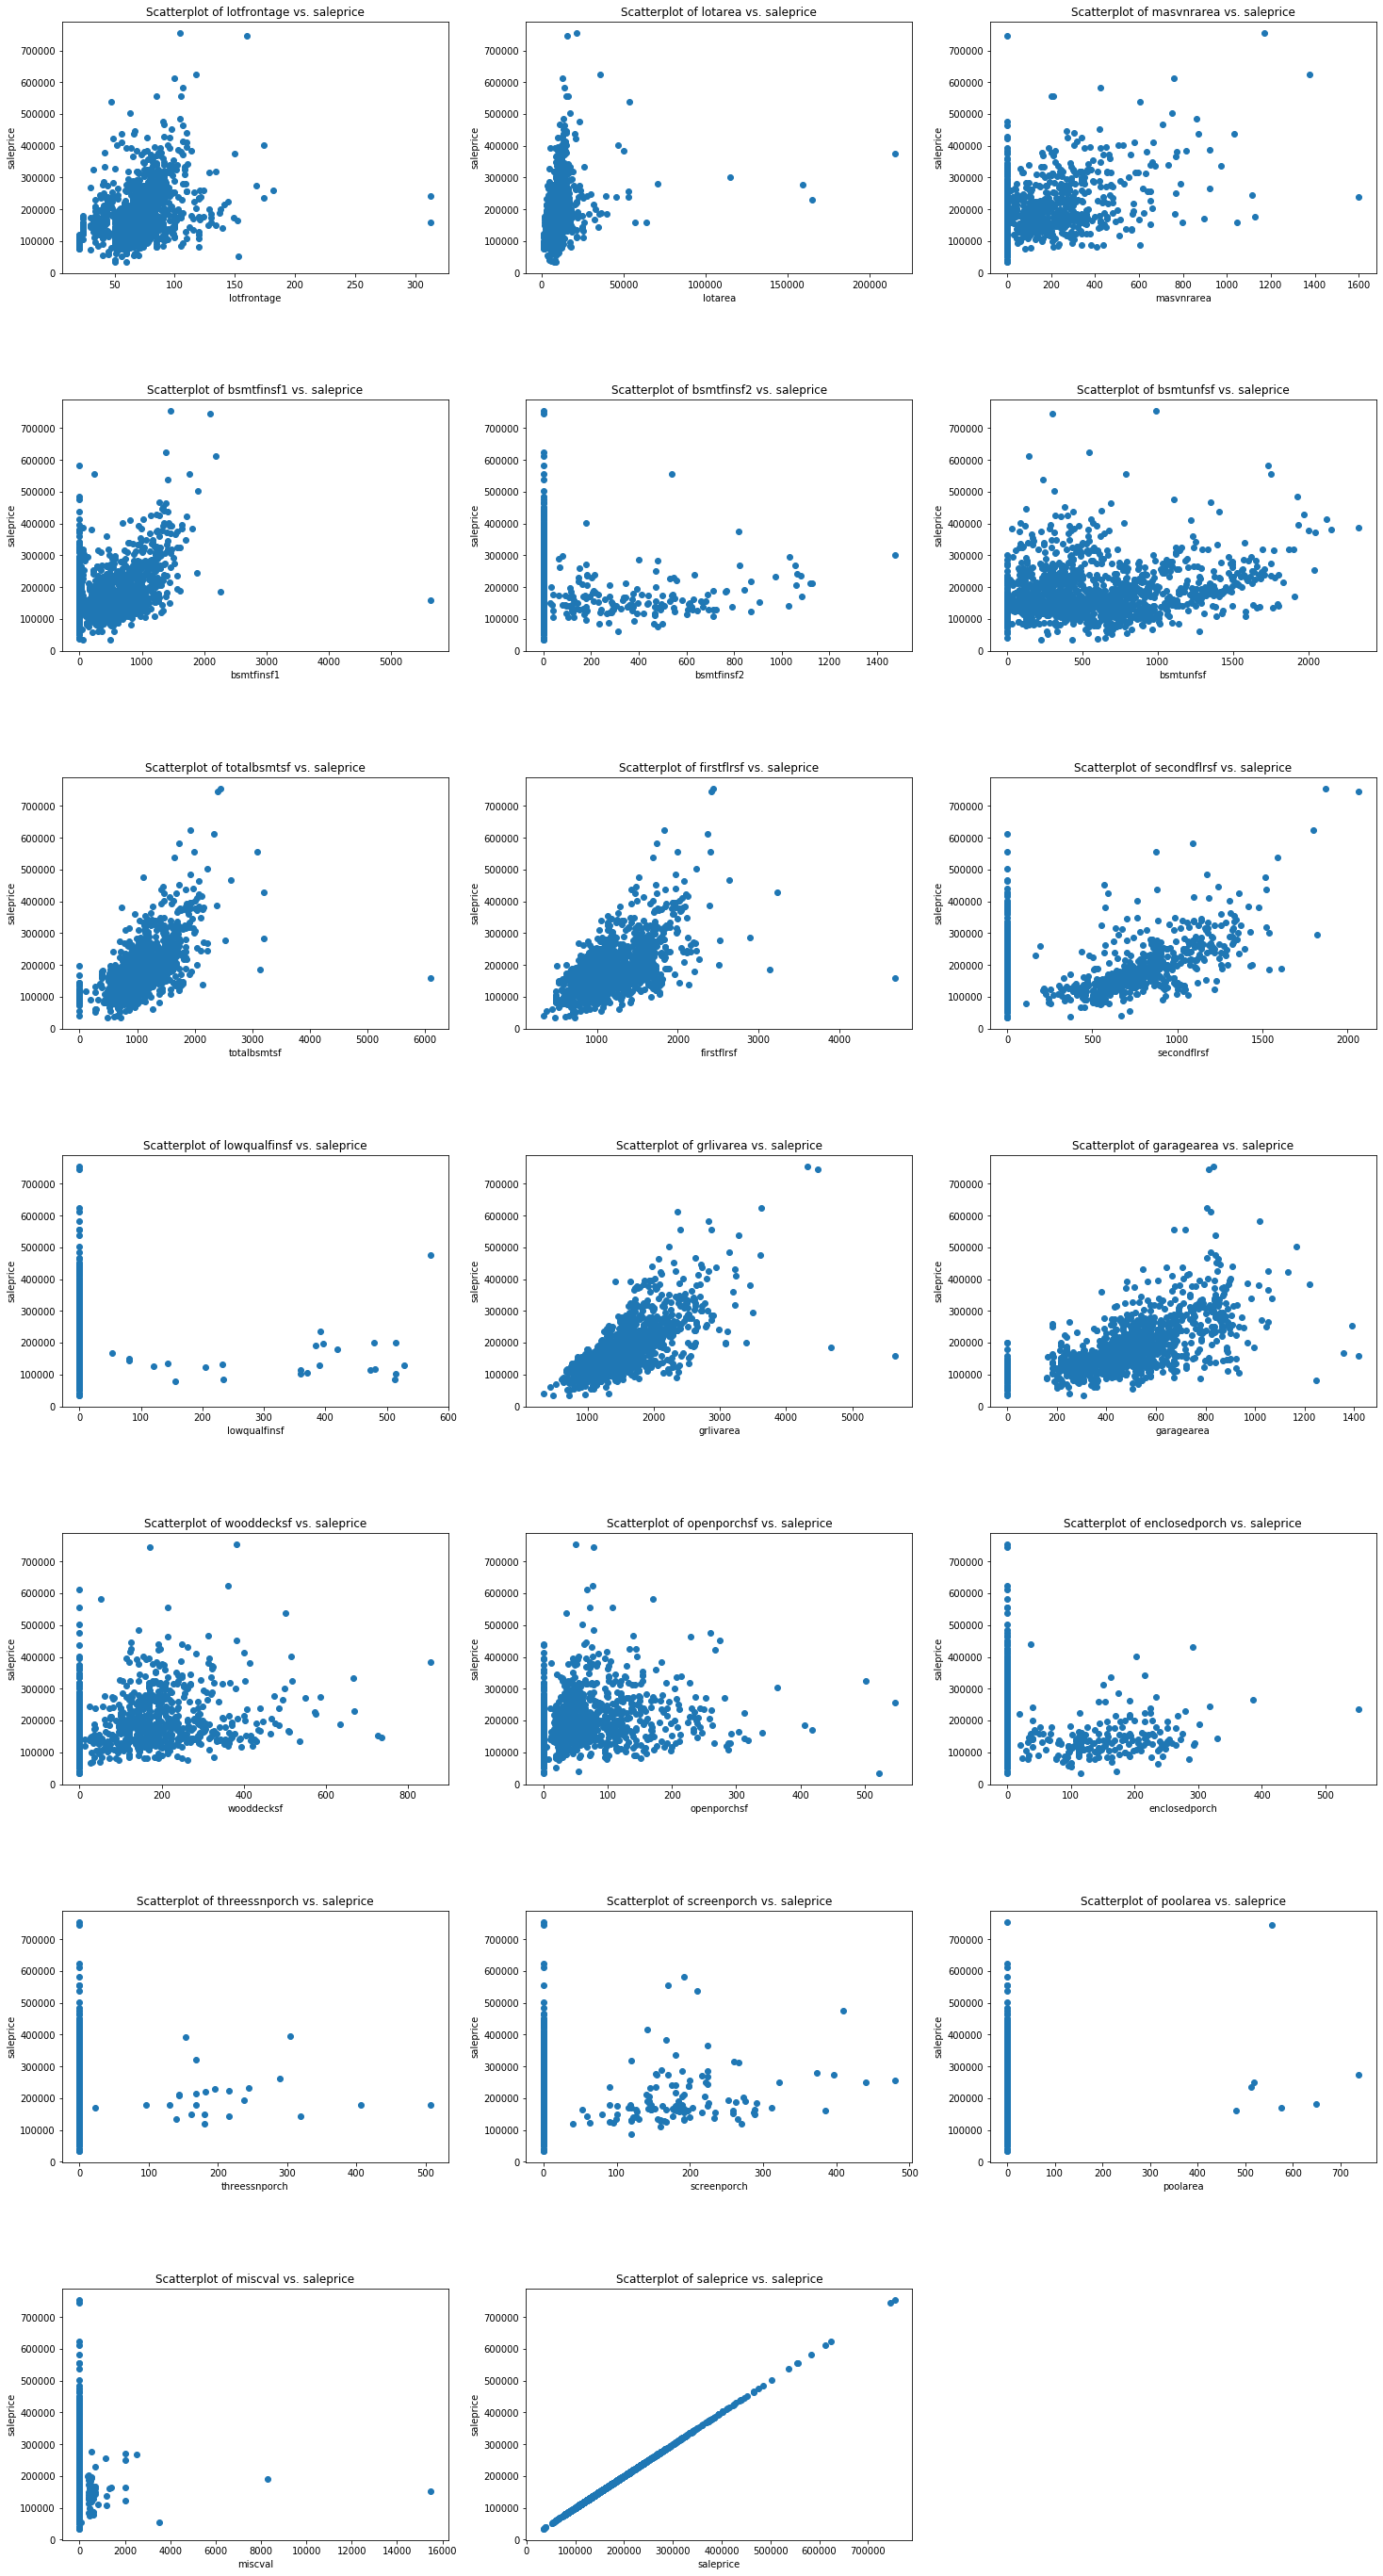

In [585]:
# Visualize the continuous columns to get a sense of their distributions
cols = houses_df.select_dtypes(exclude=["category","object","datetime"]).columns[1:]
plt_cols = 3
rows = math.ceil(len(cols)/plt_cols)

plt.figure(figsize=(25,45))

for i,col in enumerate(cols):
    # col = houses_df.iloc[:, [i]].columns[0]
    plt.subplot(rows,plt_cols,(i+1))
    plt.scatter(houses_df[f"{col}"], houses_df["saleprice"])
    plt.xlabel(f"{col}")
    plt.ylabel(f"saleprice")
    plt.title(f"Scatterplot of {col} vs. saleprice")

plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [587]:
# Select the continuous variables to start looking at outliers
houses_cont = houses_df.iloc[:,1:].select_dtypes(exclude=["category","object","datetime"])

# Determine the first and third quartiles for each variable and return a series
Q1 = houses_cont.quantile(0.25)
Q3 = houses_cont.quantile(0.75)

# Calculate the Inter Quartile Range for each variable and return a series
IQR = Q3 - Q1

# Get the min and max values for the columns
col_max = houses_cont.max()
col_min = houses_cont.min()

# Get the 90th and 10th percentiles
ninetyith = houses_cont.quantile(0.9) # 90th percentile
ninetyfifth = houses_cont.quantile(0.95) # 95th percentile
ninetynineith = houses_cont.quantile(0.99) # 99th percentile
tenth = houses_cont.quantile(0.1) # 10th percentile
fifth = houses_cont.quantile(0.05) # 5th percentile
first = houses_cont.quantile(0.01) # 1st percentile

# Bring the calculations together for presentation of the IQR information
iqr_info = pd.concat([col_max,col_min,Q3,Q1,IQR,ninetyith,
    ninetyfifth,ninetynineith,tenth,fifth,first],axis=1).reset_index().rename(columns={
        "index":"variable",0.0:"MAX",1.0:"MIN",0.75:"Q3",0.25:"Q1",
        2.0:"IQR",0.9:"90th",0.95:"95th",0.99:"99th",0.1:"10th",0.05:"5th",0.01:"1st"})
iqr_info

variable       MAX      MIN         Q3         Q1       IQR  \
0     lotfrontage     313.0     21.0      80.00      60.00     20.00   
1         lotarea  215245.0   1300.0   11601.50    7553.50   4048.00   
2      masvnrarea    1600.0      0.0     164.25       0.00    164.25   
3      bsmtfinsf1    5644.0      0.0     712.25       0.00    712.25   
4      bsmtfinsf2    1474.0      0.0       0.00       0.00      0.00   
5       bsmtunfsf    2336.0      0.0     808.00     223.00    585.00   
6     totalbsmtsf    6110.0      0.0    1298.25     795.75    502.50   
7      firstflrsf    4692.0    334.0    1391.25     882.00    509.25   
8     secondflrsf    2065.0      0.0     728.00       0.00    728.00   
9    lowqualfinsf     572.0      0.0       0.00       0.00      0.00   
10      grlivarea    5642.0    334.0    1776.75    1129.50    647.25   
11     garagearea    1418.0      0.0     576.00     334.50    241.50   
12     wooddecksf     857.0      0.0     168.00       0.00    168.00   
13    openporchsf     547.0      0.0      68.00       0.00     68.00   
14  enclosedporch     552.0      0.0       0.00       0.00      0.00   
15  threessnporch     508.0      0.0       0.00       0.00      0.00   
16    screenporch     480.0      0.0       0.00       0.00      0.00   
17       poolarea     738.0      0.0       0.00       0.00      0.00   
18        miscval   15500.0      0.0       0.00       0.00      0.00   
19      saleprice  755000.0  34900.0  214000.00  129975.00  84025.00   

        90th       95th       99th      10th       5th       1st  
0       92.0     104.00     137.41      45.9     35.00     21.00  
1    14381.7   17401.15   37567.64    5000.0   3311.70   1680.00  
2      335.0     456.00     791.28       0.0      0.00      0.00  
3     1065.5    1274.00    1572.41       0.0      0.00      0.00  
4      117.2     396.20     830.38       0.0      0.00      0.00  
5     1232.0    1468.00    1797.05      74.9      0.00      0.00  
6     1602.2    1753.00    2155.05     636.9    519.30      0.00  
7     1680.0    1831.25    2219.46     756.9    672.95    520.00  
8      954.2    1141.05    1418.92       0.0      0.00      0.00  
9        0.0       0.00     360.00       0.0      0.00      0.00  
10    2158.3    2466.10    3123.48     912.0    848.00    692.18  
11     757.1     850.10    1002.79     240.0      0.00      0.00  
12     262.0     335.00     505.46       0.0      0.00      0.00  
13     130.0     175.05     285.82       0.0      0.00      0.00  
14     112.0     180.15     261.05       0.0      0.00      0.00  
15       0.0       0.00     168.00       0.0      0.00      0.00  
16       0.0     160.00     268.05       0.0      0.00      0.00  
17       0.0       0.00       0.00       0.0      0.00      0.00  
18       0.0       0.00     700.00       0.0      0.00      0.00  
19  278000.0  326100.00  442567.01  106475.0  88000.00  61815.97

In [588]:
# Construct a matrix to assist in setting the lower an upper cutoff arguments for winsorization
outlier_matrix = list()
for col in houses_cont.columns:
    # First percentile
    outliers_1st = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["1st"].values[0])
    
    # Fifth percentile
    outliers_5th = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["5th"].values[0])
    
    # Tenth percentile
    outliers_10th = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["10th"].values[0])
    
    # First quartile
    outliers_q1 = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) < iqr_info[iqr_info["variable"]==f"{col}"]["Q1"].values[0])
    
    # Third quartile
    outliers_q3 = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["Q3"].values[0])
    
    # Ninetyith percentile
    outliers_90th = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["90th"].values[0])
    
    # Ninety-Fifth percentile
    outliers_95th = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["95th"].values[0]) 
    
    # Ninety-Nineth percentile
    outliers_99th = np.count_nonzero(
        np.where(houses_cont[f"{col}"]) > iqr_info[iqr_info["variable"]==f"{col}"]["99th"].values[0])
    
    # Append the percentiles and quartiles to the outlier_matrix list
    outlier_matrix.append([col,outliers_1st,outliers_5th,outliers_10th,outliers_q1,
        outliers_q3,outliers_90th,outliers_95th,outliers_99th,])

# Convert the outlier matrix into a dataframe that contains both percentiles and quartiles ie x_tiles
x_tile_values = pd.DataFrame(outlier_matrix).rename(columns={0:"variable",1:"1st_(0.01)",2:"5th_(0.05)",3:"10th_(0.10)",4:"Q1",5:"Q3",6:"90th_(0.90)",7:"95th_(0.95)",8:"99th_(0.99)"})

# Display the x_tiles dataframe
x_tile_values

variable  1st_(0.01)  5th_(0.05)  10th_(0.10)    Q1    Q3  \
0     lotfrontage          21          35           46    60  1379   
1         lotarea        1460        1460         1460  1460     0   
2      masvnrarea           0           0            0     0   521   
3      bsmtfinsf1           0           0            0     0   504   
4      bsmtfinsf2           0           0            0     0   167   
5       bsmtunfsf           0           0           70   208   599   
6     totalbsmtsf           0         508          622   776   159   
7      firstflrsf         520         673          757   882    68   
8     secondflrsf           0           0            0     0   317   
9    lowqualfinsf           0           0            0     0    26   
10      grlivarea         693         848          912  1130     0   
11     garagearea           0           0          223   313   836   
12     wooddecksf           0           0            0     0   620   
13    openporchsf           0           0            0     0   760   
14  enclosedporch           0           0            0     0   208   
15  threessnporch           0           0            0     0    24   
16    screenporch           0           0            0     0   116   
17       poolarea           0           0            0     0     7   
18        miscval           0           0            0     0    52   
19      saleprice        1460        1460         1460  1460     0   

    90th_(0.90)  95th_(0.95)  99th_(0.99)  
0          1367         1355         1322  
1             0            0            0  
2           445          401          261  
3           262          123            0  
4           154          120           69  
5           213            0            0  
6             0            0            0  
7             0            0            0  
8           226          146           14  
9            26           26           16  
10            0            0            0  
11          667          577          432  
12          573          530          453  
13          729          704          636  
14          189          180          168  
15           24           24           19  
16          116          108          100  
17            7            7            7  
18           52           52           26  
19            0            0            0

Now that I have an idea where the outliers sit in relation to their quartile and percentile values, I can get an idea about where to set the lower and upper cuts for the winsorization function.

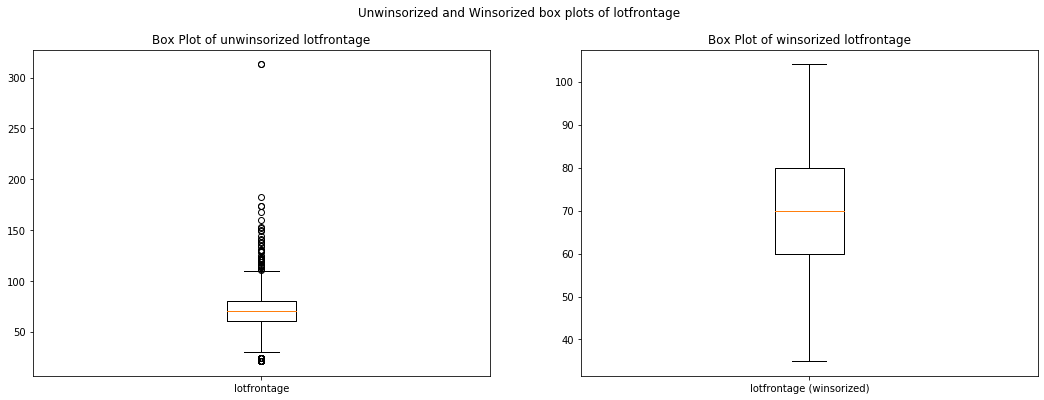

'lotfrontage - IQR Threshold:  1.5 | Outliers: 0'

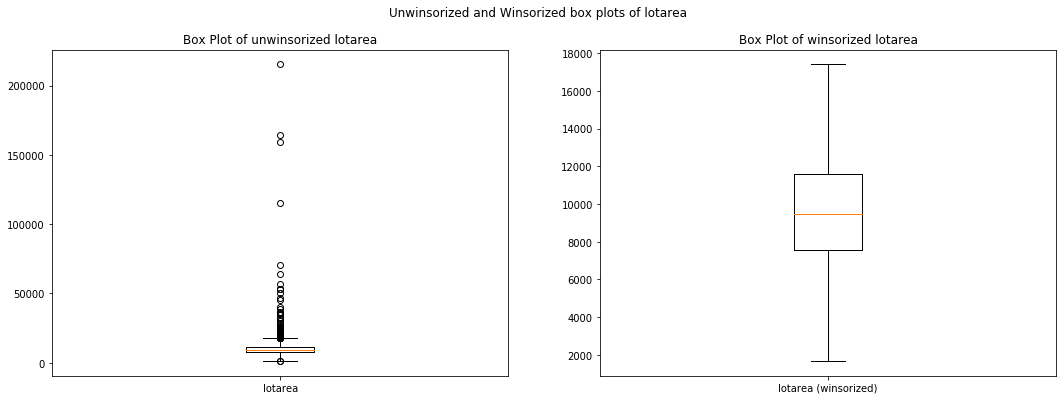

'lotarea - IQR Threshold:  1.5 | Outliers: 0'

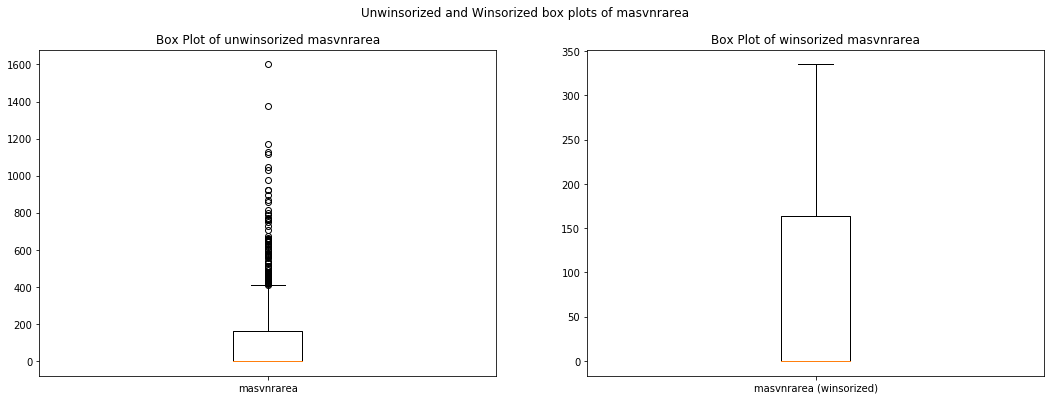

'masvnrarea - IQR Threshold:  1.5 | Outliers: 0'

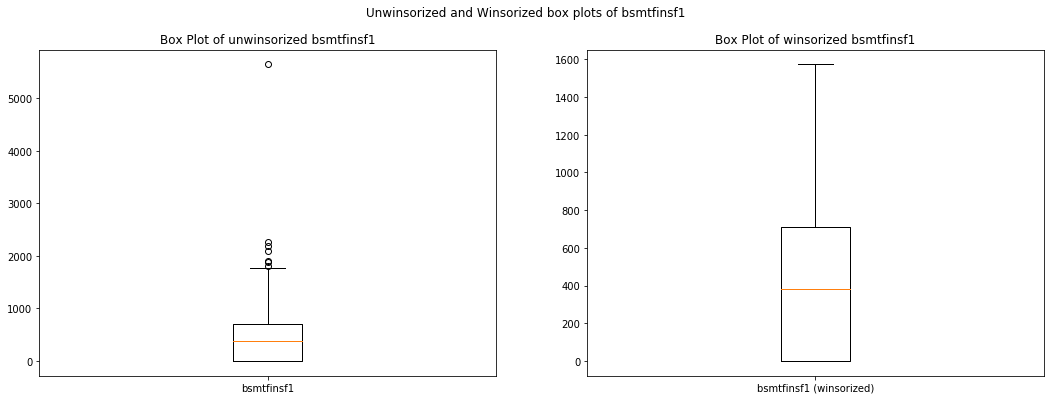

'bsmtfinsf1 - IQR Threshold:  1.5 | Outliers: 0'

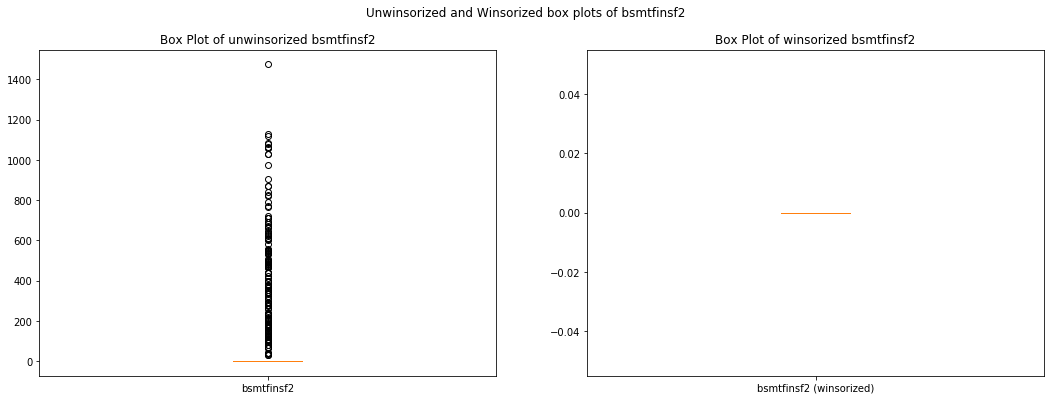

'bsmtfinsf2 - IQR Threshold:  1.5 | Outliers: 0'

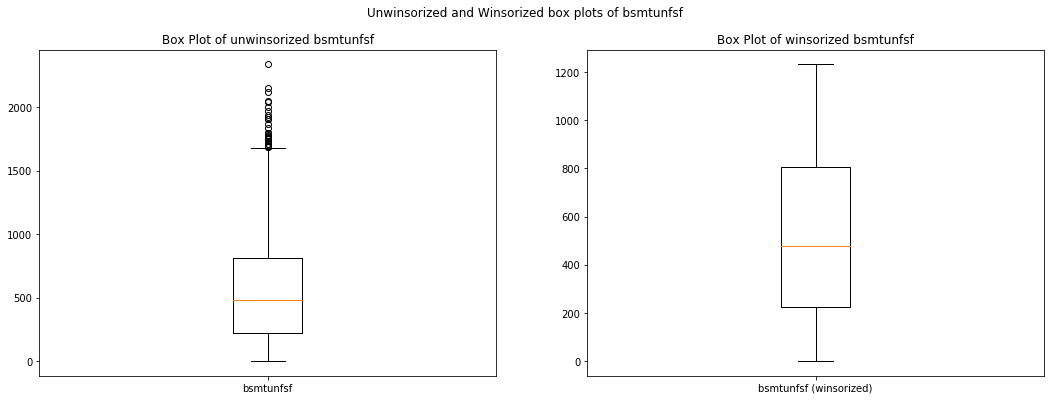

'bsmtunfsf - IQR Threshold:  1.5 | Outliers: 0'

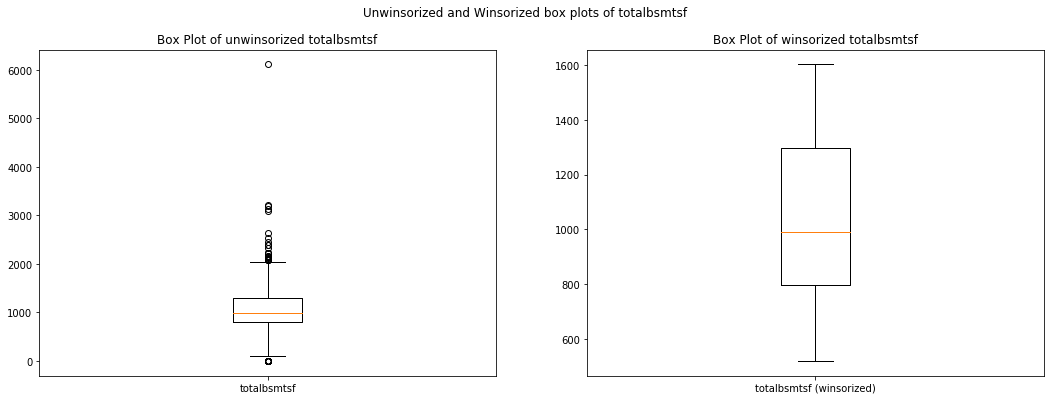

'totalbsmtsf - IQR Threshold:  1.5 | Outliers: 0'

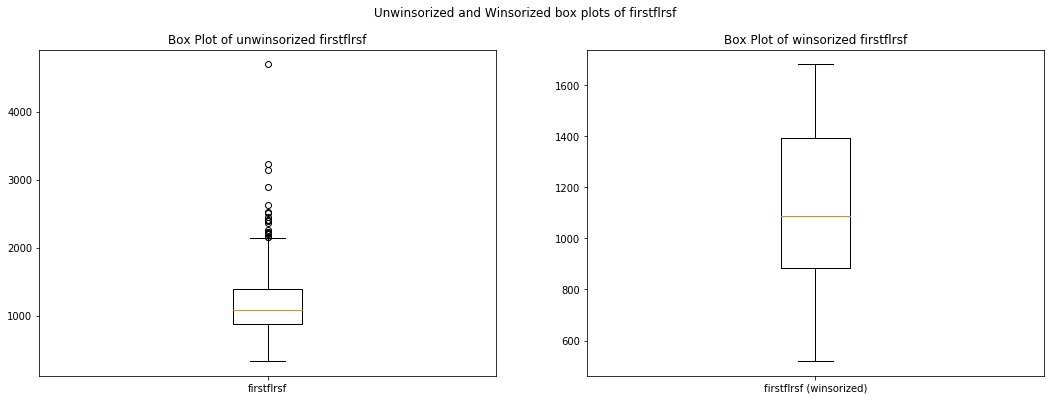

'firstflrsf - IQR Threshold:  1.5 | Outliers: 0'

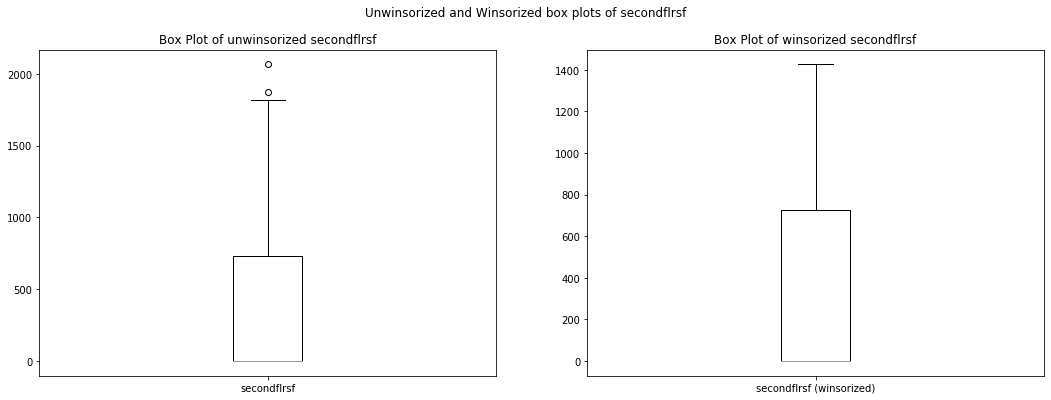

'secondflrsf - IQR Threshold:  1.5 | Outliers: 0'

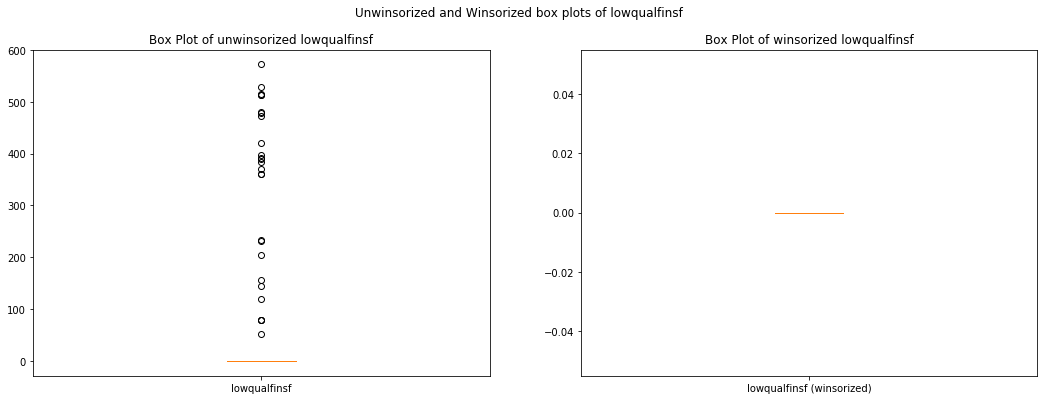

'lowqualfinsf - IQR Threshold:  1.5 | Outliers: 0'

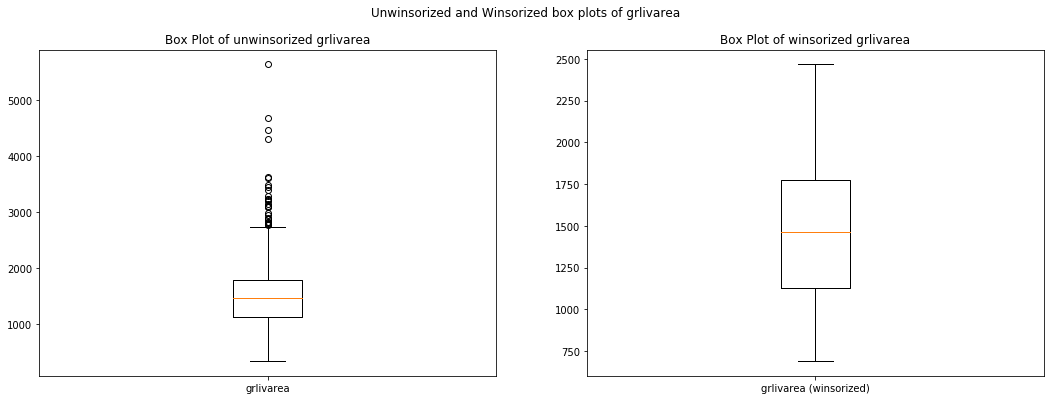

'grlivarea - IQR Threshold:  1.5 | Outliers: 0'

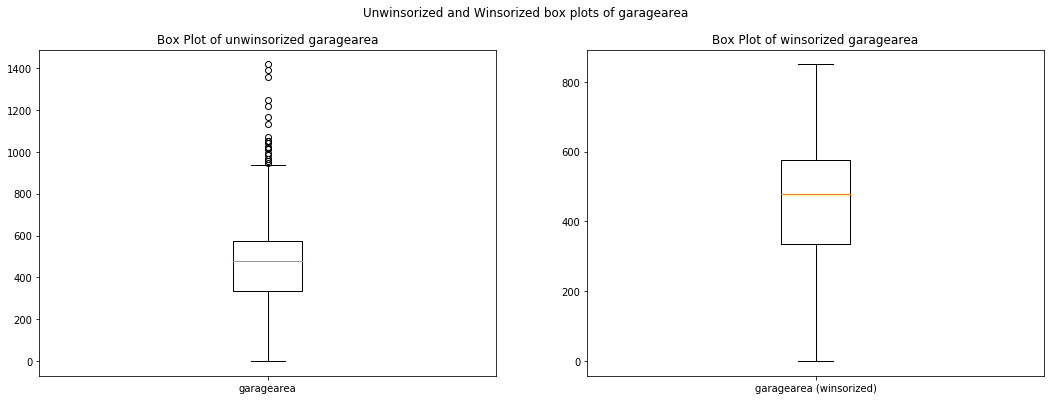

'garagearea - IQR Threshold:  1.5 | Outliers: 0'

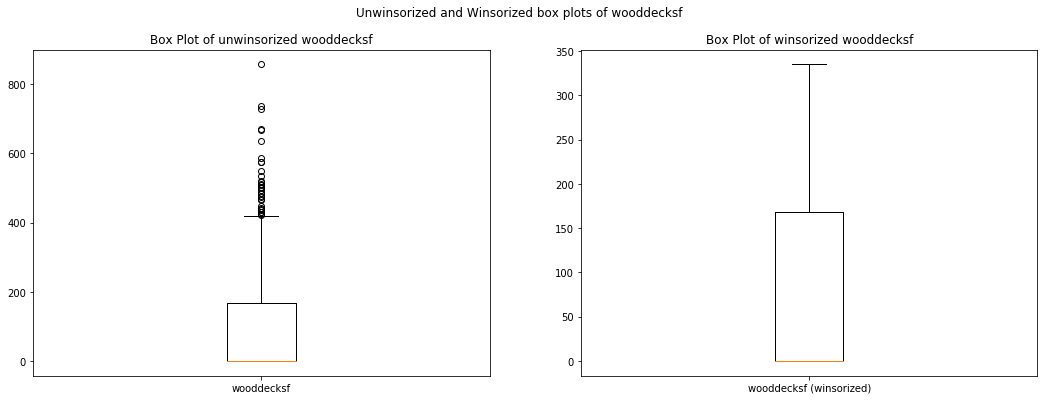

'wooddecksf - IQR Threshold:  1.5 | Outliers: 0'

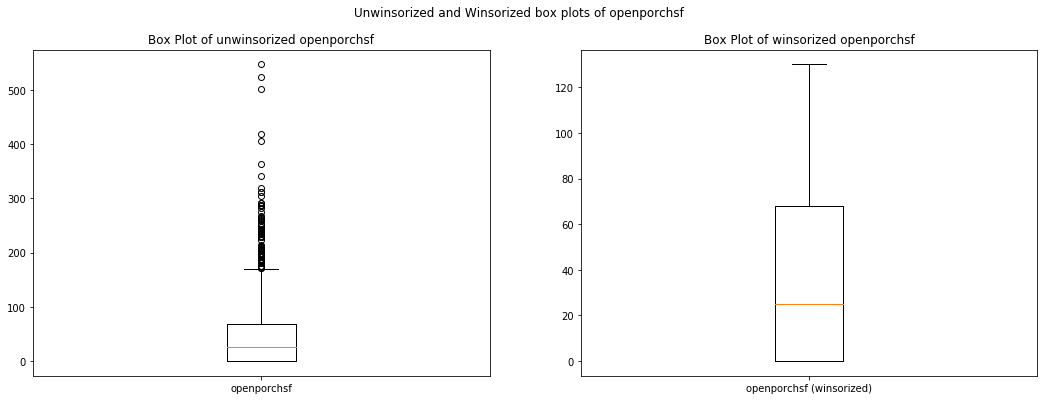

'openporchsf - IQR Threshold:  1.5 | Outliers: 0'

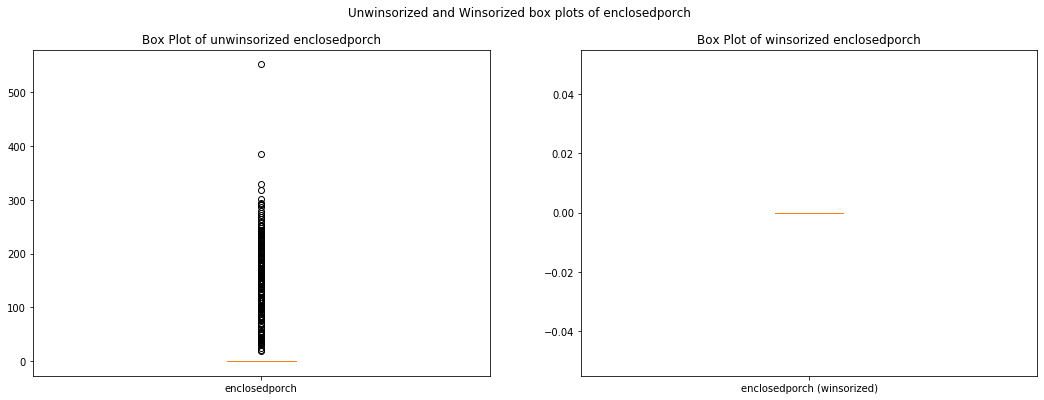

'enclosedporch - IQR Threshold:  1.5 | Outliers: 0'

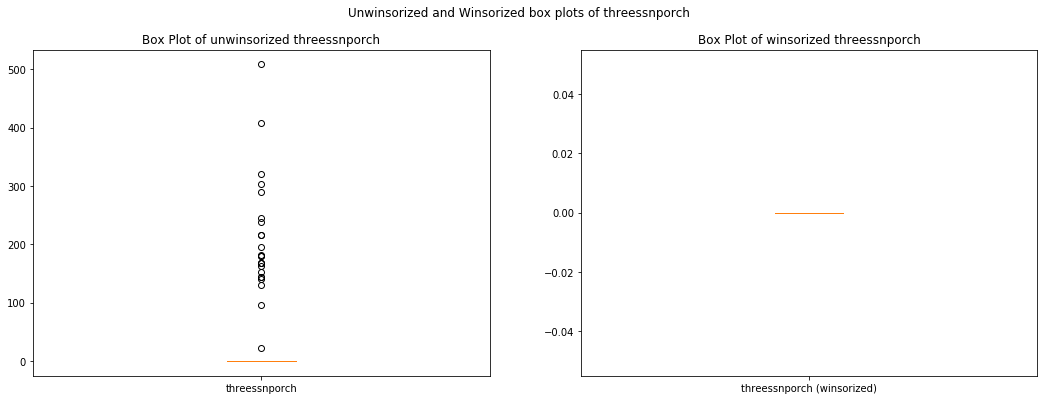

'threessnporch - IQR Threshold:  1.5 | Outliers: 0'

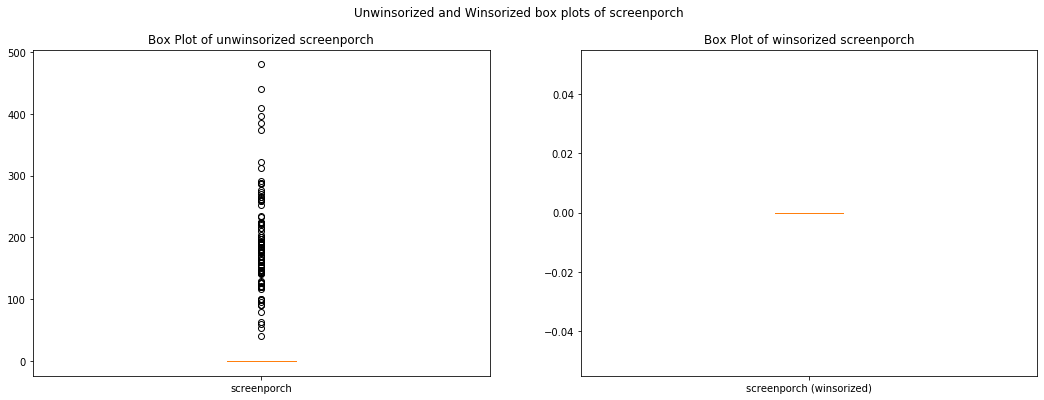

'screenporch - IQR Threshold:  1.5 | Outliers: 0'

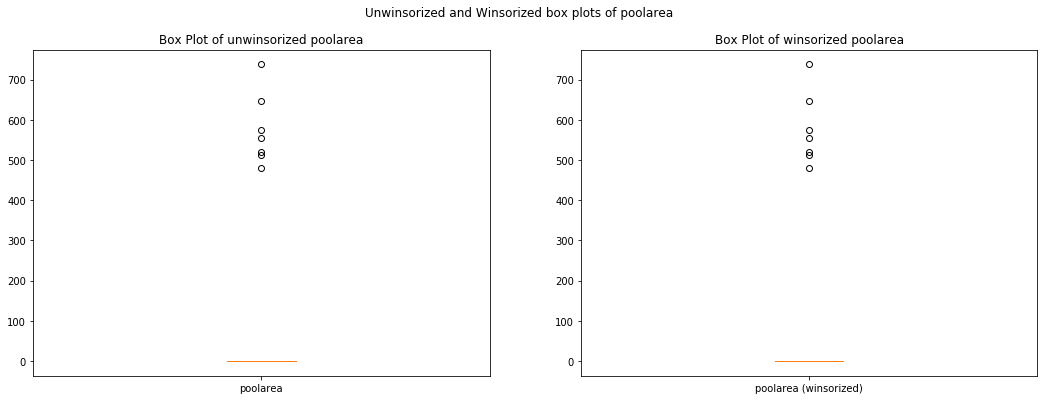

'poolarea - IQR Threshold:  1.5 | Outliers: 7'

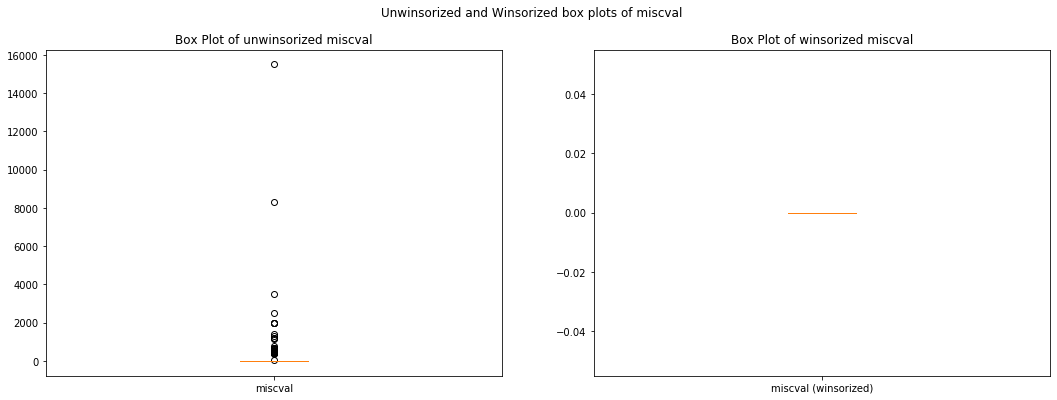

'miscval - IQR Threshold:  1.5 | Outliers: 0'

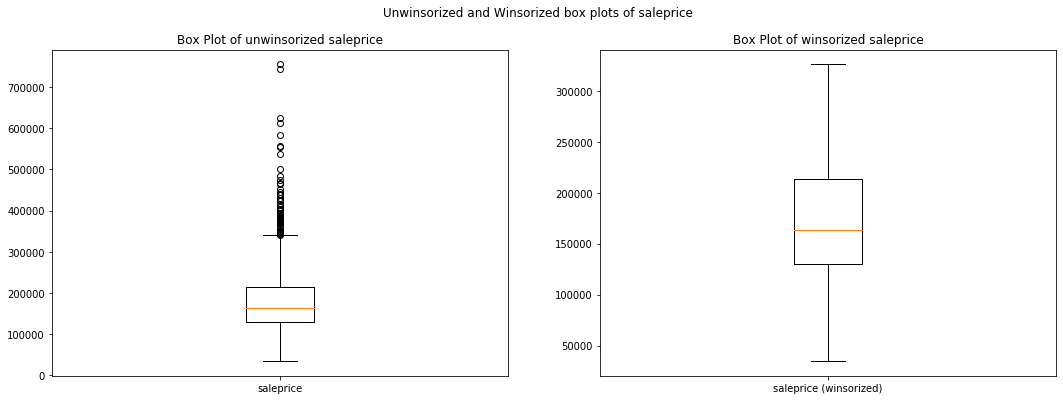

'saleprice - IQR Threshold:  1.5 | Outliers: 0'

In [592]:
# Create a dict to store columns and winsorization cutoff values
winsorize_vals = dict(
    lotfrontage=(0.05, 0.05),
    lotarea=(0.01, 0.05),
    masvnrarea=(0.00, 0.10),
    bsmtfinsf1=(0.0,0.01),
    bsmtfinsf2=(0.00,0.15),
    bsmtunfsf=(0.05,0.10),
    totalbsmtsf=(0.05,0.10),
    firstflrsf=(0.01,0.10),
    secondflrsf=(0.0,0.01),
    lowqualfinsf=(0.00,0.10),
    grlivarea=(0.01,0.05),
    garagearea=(0.05,0.05),
    wooddecksf=(0.0,0.05),
    openporchsf=(0.0,0.10),
    enclosedporch=(0.0,0.15),
    threessnporch=(0.0,0.05),
    screenporch=(0.0,0.10),
    poolarea=(0.00,0.00),
    miscval=(0.00,0.05),
    saleprice=(0.00,0.05)
)

# Plot the winsorized values for comparison sake and see if your missing any outliers 
for i, (k,v) in enumerate(winsorize_vals.items()):
    # print(f"index: {i}, key: {k}, value: {v}")
    winsorized_comparison(houses_df,k,v)

In [593]:
# Now that the outliers have been eliminated, join winsorized columns to the life_expectancy_df dataframe
houses_winsorized = houses_df.copy()

for i, (k,v) in enumerate(winsorize_vals.items()):
    houses_winsorized[f"{k}_winsorized"] = winsorize(houses_winsorized[k], v)

# Take a look at the new dataframe and verify the new columns
houses_winsorized.iloc[:,-19:].sample(n=3).T

1243      212       866 
lotarea_winsorized         10625.0   10420.0   10656.0
masvnrarea_winsorized         81.0       0.0     274.0
bsmtfinsf1_winsorized        885.0      36.0       0.0
bsmtfinsf2_winsorized          0.0       0.0       0.0
bsmtunfsf_winsorized           0.0    1176.0    1232.0
totalbsmtsf_winsorized      1053.0    1212.0    1602.0
firstflrsf_winsorized       1173.0    1212.0    1646.0
secondflrsf_winsorized         0.0       0.0       0.0
lowqualfinsf_winsorized        0.0       0.0       0.0
grlivarea_winsorized        1173.0    1212.0    1646.0
garagearea_winsorized        528.0     460.0     850.0
wooddecksf_winsorized          0.0     100.0     192.0
openporchsf_winsorized       120.0      22.0      80.0
enclosedporch_winsorized       0.0       0.0       0.0
threessnporch_winsorized       0.0       0.0       0.0
screenporch_winsorized         0.0       0.0       0.0
poolarea_winsorized            0.0       0.0       0.0
miscval_winsorized             0.0       0.0       0.0
saleprice_winsorized      170000.0  186000.0  248900.0

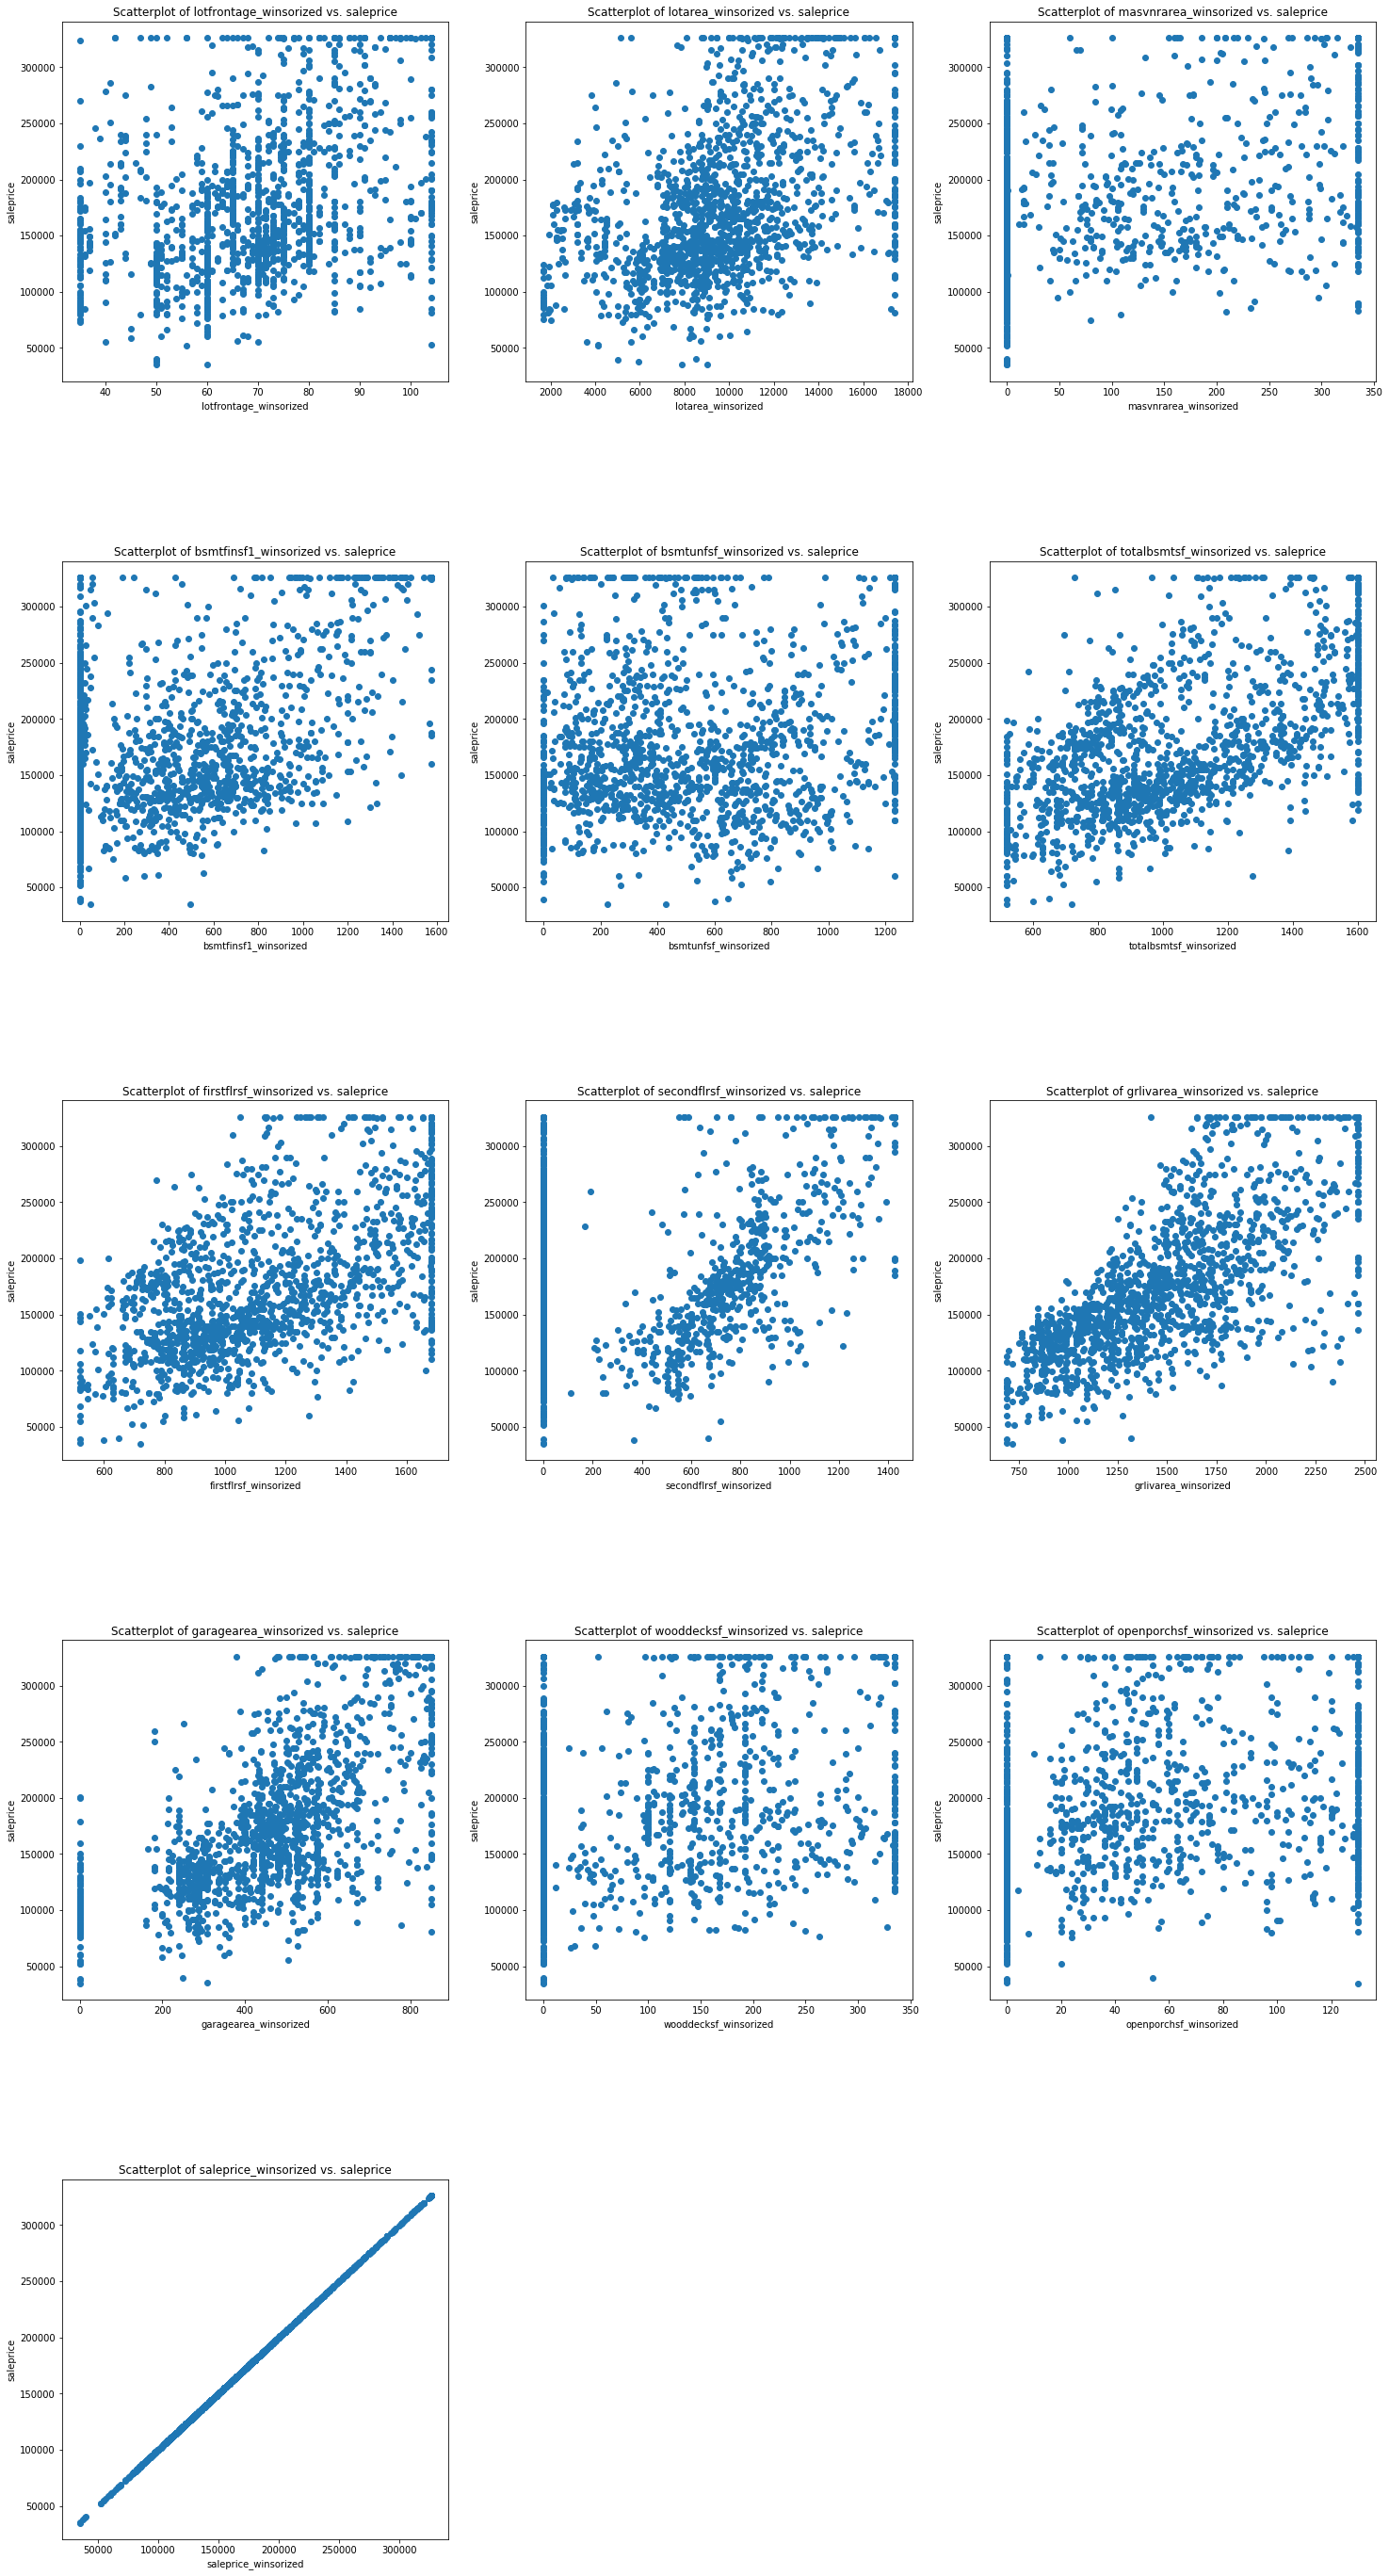

In [610]:
# Re-visualize the continuous columns to get a sense of their relationship to the target variable (saleprice_winsorized)

# First remove the columns that will not reflection a correlation to the target variable
cols = [col for col in test_df.columns if col not in ["bsmtfinsf2_winsorized", 
    "lowqualfinsf_winsorized", "enclosedporch_winsorized", 
    "threessnporch_winsorized", "screenporch_winsorized", 
    "poolarea_winsorized", "miscval_winsorized"]][-13:]

plt_cols = 3
rows = math.ceil(len(cols)/plt_cols)

plt.figure(figsize=(25,45))

for i,col in enumerate(cols):
    # col = houses_df.iloc[:, [i]].columns[0]
    plt.subplot(rows,plt_cols,(i+1))
    plt.scatter(houses_winsorized[f"{col}"], houses_winsorized["saleprice_winsorized"])
    plt.xlabel(f"{col}")
    plt.ylabel(f"saleprice")
    plt.title(f"Scatterplot of {col} vs. saleprice")

plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [613]:
# Take a look at the correlations between target variable and the other continuous variables
corr_matrix = houses_winsorized[cols].corr()
corr_matrix

lotfrontage_winsorized  lotarea_winsorized  \
lotfrontage_winsorized                1.000000            0.628184   
lotarea_winsorized                    0.628184            1.000000   
masvnrarea_winsorized                 0.227652            0.141135   
bsmtfinsf1_winsorized                 0.161075            0.212478   
bsmtunfsf_winsorized                  0.126692            0.073019   
totalbsmtsf_winsorized                0.359741            0.365644   
firstflrsf_winsorized                 0.405644            0.444907   
secondflrsf_winsorized                0.076357            0.115970   
grlivarea_winsorized                  0.372376            0.431603   
garagearea_winsorized                 0.361364            0.343995   
wooddecksf_winsorized                 0.113002            0.193903   
openporchsf_winsorized                0.164944            0.167232   
saleprice_winsorized                  0.395807            0.436870   

                        masvnrarea_winsorized  bsmtfinsf1_winsorized  \
lotfrontage_winsorized               0.227652               0.161075   
lotarea_winsorized                   0.141135               0.212478   
masvnrarea_winsorized                1.000000               0.245307   
bsmtfinsf1_winsorized                0.245307               1.000000   
bsmtunfsf_winsorized                 0.079275              -0.542737   
totalbsmtsf_winsorized               0.346881               0.448964   
firstflrsf_winsorized                0.327934               0.377628   
secondflrsf_winsorized               0.132788              -0.166115   
grlivarea_winsorized                 0.352885               0.127856   
garagearea_winsorized                0.380507               0.277077   
wooddecksf_winsorized                0.165329               0.212452   
openporchsf_winsorized               0.184966               0.092983   
saleprice_winsorized                 0.443404               0.381578   

                        bsmtunfsf_winsorized  totalbsmtsf_winsorized  \
lotfrontage_winsorized              0.126692                0.359741   
lotarea_winsorized                  0.073019                0.365644   
masvnrarea_winsorized               0.079275                0.346881   
bsmtfinsf1_winsorized              -0.542737                0.448964   
bsmtunfsf_winsorized                1.000000                0.365852   
totalbsmtsf_winsorized              0.365852                1.000000   
firstflrsf_winsorized               0.265455                0.844337   
secondflrsf_winsorized              0.044255               -0.250935   
grlivarea_winsorized                0.242744                0.385309   
garagearea_winsorized               0.139628                0.491131   
wooddecksf_winsorized              -0.028455                0.238187   
openporchsf_winsorized              0.144576                0.255772   
saleprice_winsorized                0.189464                0.633738   

                        firstflrsf_winsorized  secondflrsf_winsorized  \
lotfrontage_winsorized               0.405644                0.076357   
lotarea_winsorized                   0.444907                0.115970   
masvnrarea_winsorized                0.327934                0.132788   
bsmtfinsf1_winsorized                0.377628               -0.166115   
bsmtunfsf_winsorized                 0.265455                0.044255   
totalbsmtsf_winsorized               0.844337               -0.250935   
firstflrsf_winsorized                1.000000               -0.246843   
secondflrsf_winsorized              -0.246843                1.000000   
grlivarea_winsorized                 0.499174                0.684005   
garagearea_winsorized                0.484727                0.136974   
wooddecksf_winsorized                0.235429                0.083955   
openporchsf_winsorized               0.212289                0.220163   
saleprice_winsorized                 0.604164                0.313743   

  

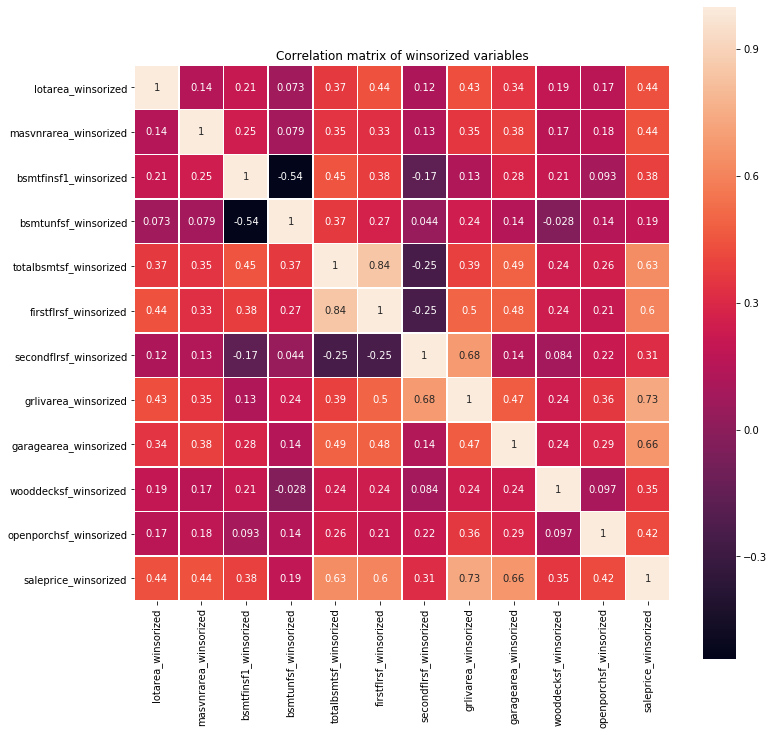

In [617]:
# Get a column count to set the figure size
col_count = len(corr_matrix.iloc[1:,1:].columns)

# Plot the correlation matrix
corr_plot(corr_matrix.iloc[1:,1:],(col_count,col_count))

The condinuous variables that I'll include in the model are: _totalbsmtsf_winsorized_, _firstflsf_winsorized_, _grlivarea_winsorized_, and _garagearea_winsorized_

Begin exploring the categorical variables and their relationship to the target variable.

In [643]:
# To make for clearer printing get the length of the longest column name and that column name
max_length, longest_col_name = max([len(x),x] for x in list(houses_winsorized.select_dtypes(include=["object",
    "category","datetime"]).columns))

# Print out the number of unique values for each variable to help identify categorical varaibles
categorical_dict = dict()
for col in houses_winsorized.select_dtypes(include=["object","category"]).columns:
    # print(f"{col:<{max_length}}: {len(houses_winsorized[col].unique()):>{4}}")
    categorical_dict.update({f"{col}":len(houses_winsorized[col].unique())})

pd.DataFrame.from_dict(categorical_dict,orient="index", columns=["Unique Values"])

Unique Values
mssubclass                15
mszoning                   5
street                     2
lotshape                   4
landcontour                4
utilities                  2
lotconfig                  5
landslope                  3
neighborhood              25
condition1                 9
condition2                 8
bldgtype                   5
housestyle                 8
overallqual               10
overallcond                9
roofstyle                  6
roofmatl                   8
exterior1st               15
exterior2nd               16
masvnrtype                 5
exterqual                  4
extercond                  5
foundation                 6
bsmtqual                   5
bsmtcond                   5
bsmtexposure               5
bsmtfintype1               7
bsmtfintype2               7
heating                    6
heatingqc                  5
centralair                 2
electrical                 6
bsmtfullbath               4
bsmthalfbath               3
fullbath                   4
halfbath                   3
bedroomabvgr               8
kitchenabvgr               4
kitchenqual                4
totrmsabvgrd              12
functional                 7
fireplaces                 4
fireplacequ                6
garagetype                 7
garagefinish               4
garagecars                 5
garagequal                 6
garagecond                 6
paveddrive                 3
poolqc                     4
miscfeature                5
saletype                   9
salecondition              6

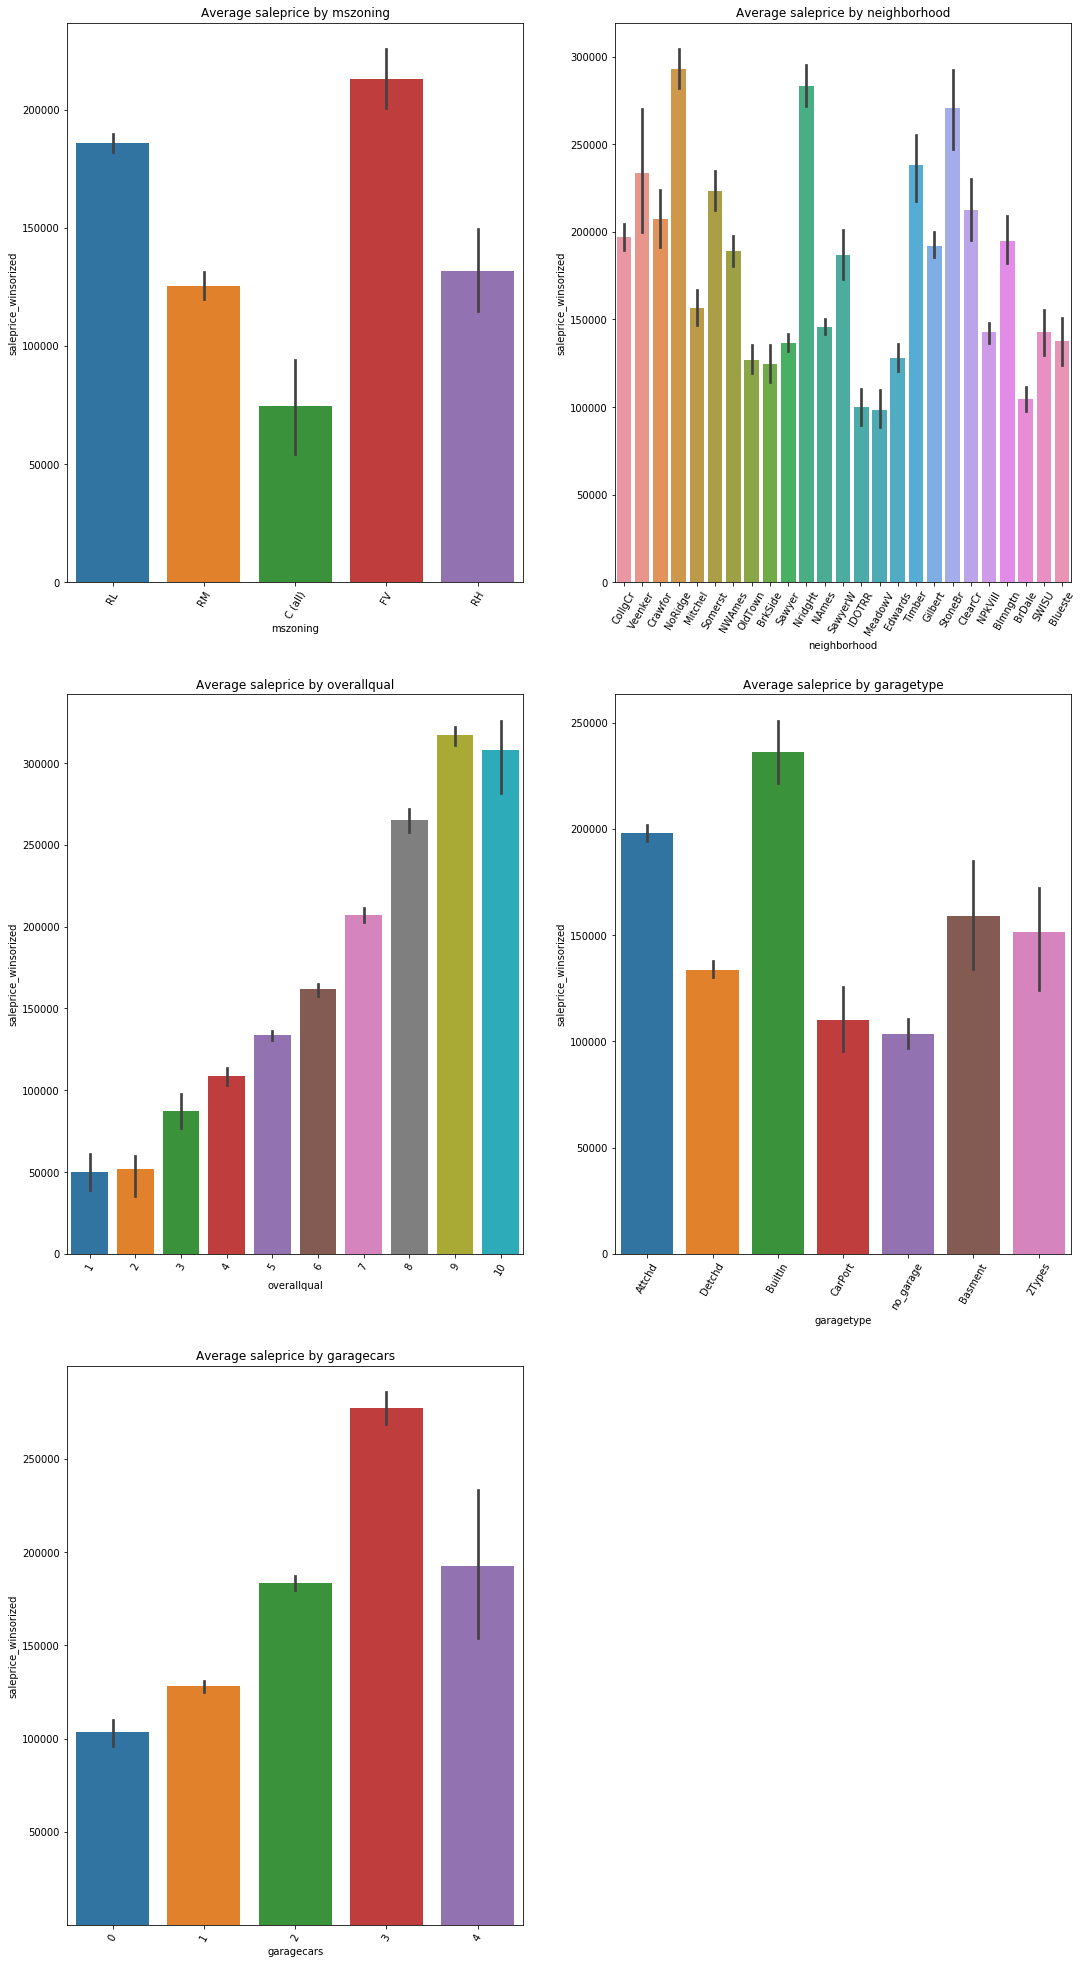

In [652]:
# Create a list of categorical variables that appear to have a relationship with the target variable
col_list = ["mszoning","neighborhood","overallqual","garagetype","garagecars"]

# Set the number of columns for the plot
fig_cols = 2

# Calculate the number for rows for the subplots
fig_rows = math.ceil(len(col_list)/fig_cols)

plt.figure(figsize=(18,35))


for i, col in enumerate(col_list):
    plt.subplot(fig_rows,fig_cols,i+1)

    sns.barplot(houses_winsorized[f"{col}"], houses_winsorized["saleprice_winsorized"])
    plt.xticks(rotation=60)
    plt.title(f"Average saleprice by {col}")

b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
# plt.yticks(rotation=360) 

plt.show();

### Feature Engineering

In [689]:
# Pull selected continuous columns into a new dataframe to be joined with the engineered columns for the model.
continuous_cols = ["saleprice_winsorized", "totalbsmtsf_winsorized", "firstflrsf_winsorized", 
    "grlivarea_winsorized", "garagearea_winsorized"]
reg_model = houses_winsorized[continuous_cols].copy()

# Add a column for the age of the home when sold
reg_model["age_at_sale"] = ((houses_working["yrsold"] - houses_working["yearbuilt"]))

# Append dummy columns for the follow categorical columns: "mszoning","neighborhood","overallqual","garagetype","garagecars"
# Append dummies for the "mszoning" categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_winsorized["mszoning"], prefix="mszoning",  drop_first=True)], axis=1)

# Append dummies for the "neighborhood" categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_winsorized["neighborhood"], prefix="neighborhood", drop_first=True)], axis=1)

# Append dummies for the "overallqual" categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_winsorized["overallqual"], prefix="overallqual", drop_first=True)], axis=1)

# Append dummies for the "garagetype" categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_winsorized["garagetype"], prefix="garagetype", drop_first=True)], axis=1)

# Append dummies for the "garagecars" categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_winsorized["garagecars"], prefix="garagecars", drop_first=True)], axis=1)

# Create a list of column names for the 
dummy_column_names = list(pd.get_dummies(houses_raw.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_raw.street, prefix="neighborhood", 
    drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_raw.street, prefix="overallqual", 
    drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_raw.street, prefix="garagetype", 
    drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_raw.street, prefix="garagecars", 
    drop_first=True).columns)

In [690]:
reg_model.sample(n=4).T

136     64      804     1081
saleprice_winsorized    174000  219500  118000  133000
totalbsmtsf_winsorized    1304    1057     936    1040
firstflrsf_winsorized     1680    1057    1128    1040
grlivarea_winsorized      1682    2034    1128    1040
garagearea_winsorized      530     645     286     308
age_at_sale                 38      12      52      47
mszoning_FV                  0       0       0       0
mszoning_RH                  0       0       0       0
mszoning_RL                  1       1       1       1
mszoning_RM                  0       0       0       0
neighborhood_Blueste         0       0       0       0
neighborhood_BrDale          0       0       0       0
neighborhood_BrkSide         0       0       0       0
neighborhood_ClearCr         0       0       0       0
neighborhood_CollgCr         0       1       0       0
neighborhood_Crawfor         0       0       0       0
neighborhood_Edwards         0       0       0       0
neighborhood_Gilbert         0       0       0       0
neighborhood_IDOTRR          0       0       0       0
neighborhood_MeadowV         0       0       0       0
neighborhood_Mitchel         0       0       0       0
neighborhood_NAmes           0       0       1       0
neighborhood_NPkVill         0       0       0       0
neighborhood_NWAmes          1       0       0       0
neighborhood_NoRidge         0       0       0       0
neighborhood_NridgHt         0       0       0       0
neighborhood_OldTown         0       0       0       0
neighborhood_SWISU           0       0       0       0
neighborhood_Sawyer          0       0       0       1
neighborhood_SawyerW         0       0       0       0
neighborhood_Somerst         0       0       0       0
neighborhood_StoneBr         0       0       0       0
neighborhood_Timber          0       0       0       0
neighborhood_Veenker         0       0       0       0
overallqual_2                0       0       0       0
overallqual_3                0       0       0       0
overallqual_4                0       0       0       0
overallqual_5                0       0       1       1
overallqual_6                0       0       0       0
overallqual_7                1       1       0       0
overallqual_8                0       0       0       0
overallqual_9                0       0       0       0
overallqual_10               0       0       0       0
garagetype_Attchd            1       1       1       1
garagetype_Basment           0       0       0       0
garagetype_BuiltIn           0       0       0       0
garagetype_CarPort           0       0       0       0
garagetype_Detchd            0       0       0       0
garagetype_no_garage         0       0       0       0
garagecars_1                 0       0       1       1
garagecars_2                 1       1       0       0
garagecars_3                 0       0       0       0
garagecars_4                 0       0       0       0

In [699]:
# Y is the target variable
Y = reg_model["saleprice_winsorized"]

# X is the feature set 
X = reg_model[list(reg_model.iloc[:,1:])]

In [718]:
# Run a K-Fold cross-result test
avg_scores = get_k_fold_scores(Y,X)
avg_scores

Fold  Holdout  Mean_Score
0     1       20   86.998185

I trained the reg_model using K-Fold cross-validation with a 20% holdout.  For a single fold, the mean score was 86.998% which should indicate that overfitting isn't an issue.

In [729]:
# Set a basis for the size of the holdout group (corss-validation)
test_size = 0.20
# Set the amount of randomness in in the sampling
random_state = 100

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = random_state)

# Fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Cross validate and print the scores
print(f"With {test_size*100}% Holdout: {lrm.fit(X_train, y_train).score(X_test, y_test)*100:.3f}%")
print(f"Testing on Sample: {lrm.fit(X,Y).score(X,Y)*100:.3f}%")

cv_scores = cross_val_score(lrm,X,Y,cv=28)
print(f"Accuracy: {cv_scores.mean():.2f}% (+/- {cv_scores.std()*2:.2f}) Mode: {stats.mode(cv_scores)[0][0]:2f}%")

# Make some predictions
m1_y_preds_train = lrm.predict(X_train)
m1_y_preds_test = lrm.predict(X_test)

# Get the model_01 scores (m1)
m1_scores = get_test_scores(lrm, X_train, X_test, y_train, y_test, m1_y_preds_train, m1_y_preds_test)
m1_scores.insert(0,"model_01")

# Print the results
print_stats(m1_scores[1], m1_scores[2], m1_scores[3], m1_scores[4], m1_scores[5], m1_scores[6])

With 20.0% Holdout: 86.536%
Testing on Sample: 88.087%
Accuracy: 0.87% (+/- 0.07) Mode: 0.765110%
R-squared of the model in the training set is: 0.8805

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: 0.8825
Mean absolute error of the prediction is: 16,308.2465
Mean squared error of the prediction is: 482,432,967.2998
Root mean squared error of the prediction is: 21,964.3567
Mean absolute percentage error of the prediction is: 10.7024


In [730]:
# Now, a Ridge regression
ridgeregr = Ridge(alpha=10**37)
ridgeregr.fit(X_train, y_train)

# Make some predictions
m2_y_preds_train = ridgeregr.predict(X_train)
m2_y_preds_test = ridgeregr.predict(X_test)

# Get the model_02 scores (m2)
m2_scores = get_test_scores(ridgeregr, X_train, X_test, y_train, y_test, m2_y_preds_train, m2_y_preds_test)
m2_scores.insert(0,"model_02")

# Print the results
print_stats(m2_scores[1], m2_scores[2], m2_scores[3], m2_scores[4], m2_scores[5], m2_scores[6])

R-squared of the model in the training set is: 0.0000

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: -0.0000
Mean absolute error of the prediction is: 49,622.0132
Mean squared error of the prediction is: 4,105,980,417.1557
Root mean squared error of the prediction is: 64,077.9246
Mean absolute percentage error of the prediction is: 35.1174


In [731]:
# This time a Lasso regression
lassoregr = Lasso(alpha=10**20.5)
lassoregr.fit(X_train, y_train)

# Making predictions here
m3_y_preds_train = lassoregr.predict(X_train)
m3_y_preds_test = lassoregr.predict(X_test)

# Get the model_03 scores (m3)
m3_scores = get_test_scores(ridgeregr, X_train, X_test, y_train, y_test, m3_y_preds_train, m3_y_preds_test)
m3_scores.insert(0,"model_03")

# Print the results
print_stats(m3_scores[1], m3_scores[2], m3_scores[3], m3_scores[4], m3_scores[5], m3_scores[6])

R-squared of the model in the training set is: 0.0000

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: -0.0000
Mean absolute error of the prediction is: 49,622.0132
Mean squared error of the prediction is: 4,105,980,417.1557
Root mean squared error of the prediction is: 64,077.9246
Mean absolute percentage error of the prediction is: 35.1174


In [732]:

# Finally, an ElasticNet regression
elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5)
elasticregr.fit(X_train, y_train)

# Making predictions here
m4_y_preds_train = elasticregr.predict(X_train)
m4_y_preds_test = elasticregr.predict(X_test)

# Get the model_04 scores (m3)
m4_scores = get_test_scores(elasticregr, X_train, X_test, y_train, y_test, m4_y_preds_train, m4_y_preds_test)
m4_scores.insert(0,"model_04")

# Print the results
print_stats(m4_scores[1], m4_scores[2], m4_scores[3], m4_scores[4], m4_scores[5], m4_scores[6])

R-squared of the model in the training set is: 0.0000

 ------------------------------ Test set statistics ------------------------------ 

R-squared of the model in the test set is: -0.0000
Mean absolute error of the prediction is: 49,622.0132
Mean squared error of the prediction is: 4,105,980,417.1557
Root mean squared error of the prediction is: 64,077.9246
Mean absolute percentage error of the prediction is: 35.1174


In [733]:
# Build a dataframe to compare the results
comparison_df = pd.DataFrame([m1_scores,m2_scores,m3_scores,m4_scores], 
    columns=["Model","Train_Score","Test_Score","MAE","MSE","RMSE","MAPE"])

In [734]:
comparison_df

Model  Train_Score  Test_Score           MAE           MSE  \
0  model_01     0.880483    0.882504  16308.246489  4.824330e+08   
1  model_02     0.000000   -0.000008  49622.013247  4.105980e+09   
2  model_03     0.000000   -0.000008  49622.013247  4.105980e+09   
3  model_04     0.000000   -0.000008  49622.013247  4.105980e+09   

           RMSE       MAPE  
0  21964.356747  10.702411  
1  64077.924570  35.117389  
2  64077.924570  35.117389  
3  64077.924570  35.117389


Model_01 appears to be the best performing model of the four that ran. It has the lowest MAE, MSE, RMSE, and MAPE scores. Additionally the R-squared for the first model looks high engough without overfitting.